### Great work team!👏 👏 👏

# Anostep results so far (updated daily)

Here are some quick analyses to look at the data so far :)
We start by accessing the data and cleaning it up

In [ ]:
import requests
import pandas as pd
from requests.auth import HTTPBasicAuth
from tabulate import tabulate

# Configuration
url = "https://www.commcarehq.org/a/atsb-project-1/api/odata/forms/v1/b81194d6348b69e2ce1880689777a556/feed"
username = "otienobrn09@gmail.com"
password = "Tracy@2013"

# Make the request
print("Connecting to CommCare OData...")
try:
    response = requests.get(
        url, 
        auth=HTTPBasicAuth(username, password),
        timeout=30
    )
    
    if response.status_code == 200:
        data = response.json()
        
        if 'value' in data and data['value']:
            # Convert to DataFrame
            df = pd.DataFrame(data['value'])
            
            print(f"\n✅ Successfully retrieved data!")
            print(f"📊 Total records: {len(df)}")
            print(f"📋 Columns: {len(df.columns)}")
            print(f"🏷️  Column names: {', '.join(df.columns.tolist()[:10])}{'...' if len(df.columns) > 10 else ''}")
            
            # Display first 20 rows in table format
            print(f"\n📋 First {min(20, len(df))} records:")
            print("=" * 100)
            
            # Show first few columns and rows for readability
            display_df = df.head(20)
            
            # If too many columns, show only first 10
            if len(df.columns) > 10:
                display_df = display_df.iloc[:, :10]
                print("(Showing first 10 columns only)")
            
            print(tabulate(display_df, headers='keys', tablefmt='grid', showindex=True))
            
            # Show data types
            print(f"\n📋 Data Types:")
            print("-" * 50)
            for col, dtype in df.dtypes.items():
                print(f"{col}: {dtype}")
            
            # Option to save to CSV
            save_option = input(f"\n💾 Save all {len(df)} records to CSV? (y/n): ").lower()
            if save_option == 'y':
                filename = "commcare_data.csv"
                df.to_csv(filename, index=False)
                print(f"✅ Data saved to {filename}")
        
        else:
            print("❌ No data found in the response")
            print("Response structure:", list(data.keys()) if isinstance(data, dict) else type(data))
    
    elif response.status_code == 401:
        print("❌ Authentication failed. Please check your username and password.")
    
    elif response.status_code == 403:
        print("❌ Access forbidden. You may not have permission to access this data.")
    
    elif response.status_code == 404:
        print("❌ Data source not found. Please check the URL.")
    
    else:
        print(f"❌ HTTP Error {response.status_code}: {response.reason}")
        print("Response:", response.text[:500])

except requests.exceptions.Timeout:
    print("❌ Request timed out. The server may be slow to respond.")

except requests.exceptions.ConnectionError:
    print("❌ Connection error. Please check your internet connection.")

except requests.exceptions.RequestException as e:
    print(f"❌ Request failed: {e}")

except Exception as e:
    print(f"❌ Unexpected error: {e}")

print("\n🔚 Script completed.")

In [ ]:
import requests
import pandas as pd
from requests.auth import HTTPBasicAuth
import json
import schedule
import time
from datetime import datetime
import logging
import threading
import sys
import os

# Configuration
url = "https://www.commcarehq.org/a/atsb-project-1/api/odata/forms/v1/b81194d6348b69e2ce1880689777a556/feed"
username = "otienobrn09@gmail.com"
password = "Tracy@2013"

# Setup logging
def setup_logging():
    """Setup logging configuration"""
    log_filename = f"commcare_sync_{datetime.now().strftime('%Y%m%d')}.log"
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_filename),
            logging.StreamHandler(sys.stdout)
        ]
    )
    return logging.getLogger(__name__)

logger = setup_logging()

def clean_column_names(df):
    """Remove 'form ' prefix from column names and clean them up"""
    
    # Create a mapping of old to new column names
    column_mapping = {}
    
    for col in df.columns:
        new_col = col
        
        # Remove "form " prefix (case insensitive)
        if col.lower().startswith('form '):
            new_col = col[5:]  # Remove first 5 characters ("form ")
        
        # Clean up other common patterns
        new_col = new_col.replace(' | ', '_')  # Replace " | " with "_"
        new_col = new_col.replace(': ', '_')   # Replace ": " with "_"
        new_col = new_col.replace(' ', '_')    # Replace spaces with underscores
        new_col = new_col.replace('__', '_')   # Replace double underscores with single
        new_col = new_col.strip('_')           # Remove leading/trailing underscores
        
        column_mapping[col] = new_col
    
    # Rename the columns
    df_clean = df.rename(columns=column_mapping)
    
    return df_clean, column_mapping

def fetch_all_data_auto(max_records=10000, batch_size=100):
    """Automatically fetch all available data"""
    auth = HTTPBasicAuth(username, password)
    all_data = []
    offset = 0
    
    logger.info(f"Starting automatic data fetch - max {max_records} records")
    
    while len(all_data) < max_records:
        try:
            params = {
                '$top': batch_size,
                '$skip': offset
            }
            
            logger.info(f"Fetching batch: records {offset} to {offset + batch_size}")
            
            response = requests.get(url, auth=auth, params=params, timeout=60)
            
            if response.status_code == 401:
                logger.error("Authentication failed - check credentials")
                break
            elif response.status_code == 403:
                logger.error("Access forbidden - check permissions")
                break
            elif response.status_code != 200:
                logger.error(f"HTTP {response.status_code} at offset {offset}")
                break
            
            data = response.json()
            
            if 'value' not in data:
                logger.error("No 'value' key in response")
                break
                
            batch_data = data['value']
            
            if not batch_data:
                logger.info("No more data available - reached end")
                break
            
            all_data.extend(batch_data)
            logger.info(f"Batch complete. Total records: {len(all_data)}")
            
            # Check if we got fewer records than requested (end of data)
            if len(batch_data) < batch_size:
                logger.info("Reached end of data")
                break
            
            offset += batch_size
            
        except requests.exceptions.Timeout:
            logger.error(f"Request timeout at offset {offset}")
            break
        except requests.exceptions.ConnectionError:
            logger.error(f"Connection error at offset {offset}")
            break
        except Exception as e:
            logger.error(f"Error fetching batch at offset {offset}: {e}")
            break
    
    if all_data:
        return pd.DataFrame(all_data)
    else:
        return None

def save_daily_data(df_clean, column_mapping):
    """Save daily data with timestamp"""
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save cleaned data with timestamp
    data_filename = f"commcare_data_{timestamp}.csv"
    df_clean.to_csv(data_filename, index=False)
    logger.info(f"Daily data saved to '{data_filename}'")
    
    # Always maintain current files for other scripts
    current_data_filename = "commcare_cleaned_data.csv"
    df_clean.to_csv(current_data_filename, index=False)
    logger.info(f"Current data updated: '{current_data_filename}'")
    
    # Save column mapping
    mapping_df = pd.DataFrame(list(column_mapping.items()), 
                             columns=['Original_Column', 'Cleaned_Column'])
    mapping_filename = f"commcare_column_mapping_{timestamp}.csv"
    mapping_df.to_csv(mapping_filename, index=False)
    
    current_mapping_filename = "commcare_column_mapping.csv"
    mapping_df.to_csv(current_mapping_filename, index=False)
    
    # Save metadata
    metadata = {
        'sync_timestamp': timestamp,
        'sync_datetime': datetime.now().isoformat(),
        'total_records': len(df_clean),
        'total_columns': len(df_clean.columns),
        'columns': list(df_clean.columns),
        'data_types': {col: str(dtype) for col, dtype in df_clean.dtypes.items()},
        'null_counts': {col: int(df_clean[col].isnull().sum()) for col in df_clean.columns}
    }
    
    metadata_filename = f"commcare_metadata_{timestamp}.json"
    with open(metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    current_metadata_filename = "commcare_metadata.json"
    with open(current_metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    logger.info(f"Metadata saved to '{metadata_filename}'")
    
    return {
        'data_file': data_filename,
        'current_data_file': current_data_filename,
        'mapping_file': mapping_filename,
        'metadata_file': metadata_filename,
        'records_count': len(df_clean)
    }

def daily_sync_job():
    """Daily synchronization job"""
    logger.info("=" * 60)
    logger.info("DAILY COMMCARE DATA SYNC STARTED")
    logger.info("=" * 60)
    
    try:
        # Test connection first
        auth = HTTPBasicAuth(username, password)
        test_response = requests.get(url, auth=auth, timeout=30, params={'$top': 1})
        
        if test_response.status_code != 200:
            logger.error(f"Connection test failed: HTTP {test_response.status_code}")
            return
        
        logger.info("Connection test successful")
        
        # Fetch all data
        df = fetch_all_data_auto()
        
        if df is None:
            logger.error("Failed to fetch data from CommCare")
            return
        
        logger.info(f"Successfully fetched {len(df)} records with {len(df.columns)} columns")
        
        # Clean column names
        logger.info("Cleaning column names...")
        df_clean, column_mapping = clean_column_names(df)
        
        # Save data
        logger.info("Saving data...")
        files = save_daily_data(df_clean, column_mapping)
        
        logger.info("=" * 60)
        logger.info("DAILY SYNC COMPLETED SUCCESSFULLY")
        logger.info(f"Records processed: {files['records_count']}")
        logger.info(f"Files updated:")
        for desc, filename in files.items():
            if desc.endswith('_file'):
                logger.info(f"  • {filename}")
        logger.info("=" * 60)
        
    except Exception as e:
        logger.error(f"Daily sync failed: {e}")
        import traceback
        logger.error("Full error details:")
        logger.error(traceback.format_exc())



def show_status():
    """Show current sync status"""
    print("\n📊 COMMCARE DATA SYNC STATUS")
    print("=" * 50)
    
    # Check if current files exist
    current_files = {
        'Data': 'commcare_cleaned_data.csv',
        'Mapping': 'commcare_column_mapping.csv', 
        'Metadata': 'commcare_metadata.json'
    }
    
    for file_type, filename in current_files.items():
        if os.path.exists(filename):
            mod_time = datetime.fromtimestamp(os.path.getmtime(filename))
            size = os.path.getsize(filename)
            print(f"✅ {file_type:8}: {filename}")
            print(f"   Last updated: {mod_time.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"   Size: {size:,} bytes")
        else:
            print(f"❌ {file_type:8}: {filename} (not found)")
    
    # Check recent log files
    log_files = [f for f in os.listdir('.') if f.startswith('commcare_sync_') and f.endswith('.log')]
    if log_files:
        latest_log = max(log_files, key=lambda f: os.path.getmtime(f))
        mod_time = datetime.fromtimestamp(os.path.getmtime(latest_log))
        print(f"\n📋 Latest log: {latest_log}")
        print(f"   Last modified: {mod_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Show next scheduled run
    jobs = schedule.get_jobs()
    if jobs:
        next_run = min(job.next_run for job in jobs)
        print(f"\n⏰ Next scheduled sync: {next_run.strftime('%Y-%m-%d %H:%M:%S')}")
    else:
        print(f"\n⏰ No scheduled syncs configured")

def main():
    print("🔄 CommCare Auto-Sync Data Loader")
    print("=" * 60)
    print("Automatic daily sync scheduled for 9:00 AM")
    print("Press Ctrl+C to stop the scheduler")
    print("=" * 60)
    
    # Schedule daily job at 9:36 AM
    schedule.every().day.at("09:36").do(daily_sync_job)
    
    # Show initial status
    show_status()
    
    try:
        logger.info("Starting CommCare data scheduler...")
        logger.info("Daily sync scheduled for 9:00 AM")
        logger.info("Press Ctrl+C to stop")
        
        # Run scheduler loop
        while True:
            schedule.run_pending()
            time.sleep(60)  # Check every minute
            
    except KeyboardInterrupt:
        print("\n⏹️  Scheduler stopped by user")
        logger.info("Scheduler stopped by user")
        print("👋 Goodbye!")

if __name__ == "__main__":
    main()

🔄 CommCare Auto-Sync Data Loader
Automatic daily sync scheduled for 9:00 AM
Press Ctrl+C to stop the scheduler

📊 COMMCARE DATA SYNC STATUS
✅ Data    : commcare_cleaned_data.csv
   Last updated: 2025-10-03 15:19:16
   Size: 1,006,371 bytes
❌ Mapping : commcare_column_mapping.csv (not found)
❌ Metadata: commcare_metadata.json (not found)

📋 Latest log: commcare_sync_20251003.log
   Last modified: 2025-10-03 15:20:27

⏰ Next scheduled sync: 2025-10-04 09:36:00
2025-10-03 15:20:27,555 - INFO - Starting CommCare data scheduler...
2025-10-03 15:20:27,557 - INFO - Daily sync scheduled for 9:00 AM
2025-10-03 15:20:27,557 - INFO - Press Ctrl+C to stop


In [ ]:
import requests
import pandas as pd
from requests.auth import HTTPBasicAuth
import json
import schedule
import time
from datetime import datetime
import logging
import threading
import sys
import os

# Configuration
url = "https://www.commcarehq.org/a/atsb-project-1/api/odata/forms/v1/b81194d6348b69e2ce1880689777a556/feed"
username = "otienobrn09@gmail.com"
password = "Tracy@2013"

# Setup logging
def setup_logging():
    """Setup logging configuration"""
    log_filename = f"commcare_sync_{datetime.now().strftime('%Y%m%d')}.log"
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_filename),
            logging.StreamHandler(sys.stdout)
        ]
    )
    return logging.getLogger(__name__)

logger = setup_logging()

def clean_column_names(df):
    """Remove 'form ' prefix from column names and clean them up"""
    
    # Create a mapping of old to new column names
    column_mapping = {}
    
    for col in df.columns:
        new_col = col
        
        # Remove "form " prefix (case insensitive)
        if col.lower().startswith('form '):
            new_col = col[5:]  # Remove first 5 characters ("form ")
        
        # Clean up other common patterns
        new_col = new_col.replace(' | ', '_')  # Replace " | " with "_"
        new_col = new_col.replace(': ', '_')   # Replace ": " with "_"
        new_col = new_col.replace(' ', '_')    # Replace spaces with underscores
        new_col = new_col.replace('__', '_')   # Replace double underscores with single
        new_col = new_col.strip('_')           # Remove leading/trailing underscores
        
        column_mapping[col] = new_col
    
    # Rename the columns
    df_clean = df.rename(columns=column_mapping)
    
    return df_clean, column_mapping

def fetch_all_data_auto(max_records=10000, batch_size=100):
    """Automatically fetch all available data"""
    auth = HTTPBasicAuth(username, password)
    all_data = []
    offset = 0
    
    logger.info(f"Starting automatic data fetch - max {max_records} records")
    
    while len(all_data) < max_records:
        try:
            params = {
                '$top': batch_size,
                '$skip': offset
            }
            
            logger.info(f"Fetching batch: records {offset} to {offset + batch_size}")
            
            response = requests.get(url, auth=auth, params=params, timeout=60)
            
            if response.status_code == 401:
                logger.error("Authentication failed - check credentials")
                break
            elif response.status_code == 403:
                logger.error("Access forbidden - check permissions")
                break
            elif response.status_code != 200:
                logger.error(f"HTTP {response.status_code} at offset {offset}")
                break
            
            data = response.json()
            
            if 'value' not in data:
                logger.error("No 'value' key in response")
                break
                
            batch_data = data['value']
            
            if not batch_data:
                logger.info("No more data available - reached end")
                break
            
            all_data.extend(batch_data)
            logger.info(f"Batch complete. Total records: {len(all_data)}")
            
            # Check if we got fewer records than requested (end of data)
            if len(batch_data) < batch_size:
                logger.info("Reached end of data")
                break
            
            offset += batch_size
            
        except requests.exceptions.Timeout:
            logger.error(f"Request timeout at offset {offset}")
            break
        except requests.exceptions.ConnectionError:
            logger.error(f"Connection error at offset {offset}")
            break
        except Exception as e:
            logger.error(f"Error fetching batch at offset {offset}: {e}")
            break
    
    if all_data:
        return pd.DataFrame(all_data)
    else:
        return None

def save_daily_data(df_clean, column_mapping):
    """Save daily data with timestamp"""
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save cleaned data with timestamp
    data_filename = f"commcare_data_{timestamp}.csv"
    df_clean.to_csv(data_filename, index=False)
    logger.info(f"Daily data saved to '{data_filename}'")
    
    # Always maintain current files for other scripts
    current_data_filename = "commcare_cleaned_data.csv"
    df_clean.to_csv(current_data_filename, index=False)
    logger.info(f"Current data updated: '{current_data_filename}'")
    
    # Save column mapping
    mapping_df = pd.DataFrame(list(column_mapping.items()), 
                             columns=['Original_Column', 'Cleaned_Column'])
    mapping_filename = f"commcare_column_mapping_{timestamp}.csv"
    mapping_df.to_csv(mapping_filename, index=False)
    
    current_mapping_filename = "commcare_column_mapping.csv"
    mapping_df.to_csv(current_mapping_filename, index=False)
    
    # Save metadata
    metadata = {
        'sync_timestamp': timestamp,
        'sync_datetime': datetime.now().isoformat(),
        'total_records': len(df_clean),
        'total_columns': len(df_clean.columns),
        'columns': list(df_clean.columns),
        'data_types': {col: str(dtype) for col, dtype in df_clean.dtypes.items()},
        'null_counts': {col: int(df_clean[col].isnull().sum()) for col in df_clean.columns}
    }
    
    metadata_filename = f"commcare_metadata_{timestamp}.json"
    with open(metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    current_metadata_filename = "commcare_metadata.json"
    with open(current_metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    logger.info(f"Metadata saved to '{metadata_filename}'")
    
    return {
        'data_file': data_filename,
        'current_data_file': current_data_filename,
        'mapping_file': mapping_filename,
        'metadata_file': metadata_filename,
        'records_count': len(df_clean)
    }

def daily_sync_job():
    """Daily synchronization job"""
    logger.info("=" * 60)
    logger.info("DAILY COMMCARE DATA SYNC STARTED")
    logger.info("=" * 60)
    
    try:
        # Test connection first
        auth = HTTPBasicAuth(username, password)
        test_response = requests.get(url, auth=auth, timeout=30, params={'$top': 1})
        
        if test_response.status_code != 200:
            logger.error(f"Connection test failed: HTTP {test_response.status_code}")
            return
        
        logger.info("Connection test successful")
        
        # Fetch all data
        df = fetch_all_data_auto()
        
        if df is None:
            logger.error("Failed to fetch data from CommCare")
            return
        
        logger.info(f"Successfully fetched {len(df)} records with {len(df.columns)} columns")
        
        # Clean column names
        logger.info("Cleaning column names...")
        df_clean, column_mapping = clean_column_names(df)
        
        # Save data
        logger.info("Saving data...")
        files = save_daily_data(df_clean, column_mapping)
        
        logger.info("=" * 60)
        logger.info("DAILY SYNC COMPLETED SUCCESSFULLY")
        logger.info(f"Records processed: {files['records_count']}")
        logger.info(f"Files updated:")
        for desc, filename in files.items():
            if desc.endswith('_file'):
                logger.info(f"  • {filename}")
        logger.info("=" * 60)
        
    except Exception as e:
        logger.error(f"Daily sync failed: {e}")
        import traceback
        logger.error("Full error details:")
        logger.error(traceback.format_exc())

def run_scheduler():
    """Run the scheduler in a separate thread"""
    logger.info("Starting CommCare data scheduler...")
    logger.info("Daily sync scheduled for 9:00 AM")
    
    while True:
        schedule.run_pending()
        time.sleep(60)  # Check every minute

def manual_sync():
    """Manual sync for immediate execution"""
    logger.info("Manual sync requested...")
    daily_sync_job()

def show_status():
    """Show current sync status"""
    print("\n📊 COMMCARE DATA SYNC STATUS")
    print("=" * 50)
    
    # Check if current files exist
    current_files = {
        'Data': 'commcare_cleaned_data.csv',
        'Mapping': 'commcare_column_mapping.csv', 
        'Metadata': 'commcare_metadata.json'
    }
    
    for file_type, filename in current_files.items():
        if os.path.exists(filename):
            mod_time = datetime.fromtimestamp(os.path.getmtime(filename))
            size = os.path.getsize(filename)
            print(f"✅ {file_type:8}: {filename}")
            print(f"   Last updated: {mod_time.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"   Size: {size:,} bytes")
        else:
            print(f"❌ {file_type:8}: {filename} (not found)")
    
    # Check recent log files
    log_files = [f for f in os.listdir('.') if f.startswith('commcare_sync_') and f.endswith('.log')]
    if log_files:
        latest_log = max(log_files, key=lambda f: os.path.getmtime(f))
        mod_time = datetime.fromtimestamp(os.path.getmtime(latest_log))
        print(f"\n📋 Latest log: {latest_log}")
        print(f"   Last modified: {mod_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Show next scheduled run
    jobs = schedule.get_jobs()
    if jobs:
        next_run = min(job.next_run for job in jobs)
        print(f"\n⏰ Next scheduled sync: {next_run.strftime('%Y-%m-%d %H:%M:%S')}")
    else:
        print(f"\n⏰ No scheduled syncs configured")

def main():
    print("🔄 CommCare Auto-Sync Data Loader")
    print("=" * 60)
    print("This tool automatically syncs CommCare data daily at 9:00 AM")
    print()
    
    # Schedule daily job at 9:00 AM
    schedule.every().day.at("09:25").do(daily_sync_job)
    
    print("Available options:")
    print("1. Start automatic scheduler (runs daily at 9:00 AM)")
    print("2. Run manual sync now")
    print("3. Show current status")
    print("4. Exit")
    
    while True:
        try:
            choice = input("\nEnter choice (1-4): ").strip()
            
            if choice == "1":
                print("\n🔄 Starting automatic scheduler...")
                print("Daily sync will run at 9:00 AM")
                print("Press Ctrl+C to stop the scheduler")
                
                try:
                    # Start scheduler in background thread
                    scheduler_thread = threading.Thread(target=run_scheduler, daemon=True)
                    scheduler_thread.start()
                    
                    # Keep main thread alive
                    while True:
                        time.sleep(10)
                        
                except KeyboardInterrupt:
                    print("\n⏹️  Scheduler stopped by user")
                    break
                    
            elif choice == "2":
                print("\n▶️  Running manual sync...")
                manual_sync()
                
            elif choice == "3":
                show_status()
                
            elif choice == "4":
                print("👋 Goodbye!")
                break
                
            else:
                print("Invalid choice. Please enter 1-4.")
                
        except (EOFError, KeyboardInterrupt):
            print("\n👋 Goodbye!")
            break

if __name__ == "__main__":
    main()

In [ ]:
import requests
import pandas as pd
from requests.auth import HTTPBasicAuth
import json
import schedule
import time
from datetime import datetime
import logging
import threading
import sys
import os

# Configuration
url = "https://www.commcarehq.org/a/atsb-project-1/api/odata/forms/v1/b81194d6348b69e2ce1880689777a556/feed"
username = "otienobrn09@gmail.com"
password = "Tracy@2013"

# Setup logging
def setup_logging():
    """Setup logging configuration"""
    log_filename = f"commcare_sync_{datetime.now().strftime('%Y%m%d')}.log"
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_filename),
            logging.StreamHandler(sys.stdout)
        ]
    )
    return logging.getLogger(__name__)

logger = setup_logging()

def clean_column_names(df):
    """Remove 'form ' prefix from column names and clean them up"""
    
    # Create a mapping of old to new column names
    column_mapping = {}
    
    for col in df.columns:
        new_col = col
        
        # Remove "form " prefix (case insensitive)
        if col.lower().startswith('form '):
            new_col = col[5:]  # Remove first 5 characters ("form ")
        
        # Clean up other common patterns
        new_col = new_col.replace(' | ', '_')  # Replace " | " with "_"
        new_col = new_col.replace(': ', '_')   # Replace ": " with "_"
        new_col = new_col.replace(' ', '_')    # Replace spaces with underscores
        new_col = new_col.replace('__', '_')   # Replace double underscores with single
        new_col = new_col.strip('_')           # Remove leading/trailing underscores
        
        column_mapping[col] = new_col
    
    # Rename the columns
    df_clean = df.rename(columns=column_mapping)
    
    return df_clean, column_mapping

def fetch_all_data_auto(max_records=10000, batch_size=100):
    """Automatically fetch all available data"""
    auth = HTTPBasicAuth(username, password)
    all_data = []
    offset = 0
    
    logger.info(f"Starting automatic data fetch - max {max_records} records")
    
    while len(all_data) < max_records:
        try:
            params = {
                '$top': batch_size,
                '$skip': offset
            }
            
            logger.info(f"Fetching batch: records {offset} to {offset + batch_size}")
            
            response = requests.get(url, auth=auth, params=params, timeout=60)
            
            if response.status_code == 401:
                logger.error("Authentication failed - check credentials")
                break
            elif response.status_code == 403:
                logger.error("Access forbidden - check permissions")
                break
            elif response.status_code != 200:
                logger.error(f"HTTP {response.status_code} at offset {offset}")
                break
            
            data = response.json()
            
            if 'value' not in data:
                logger.error("No 'value' key in response")
                break
                
            batch_data = data['value']
            
            if not batch_data:
                logger.info("No more data available - reached end")
                break
            
            all_data.extend(batch_data)
            logger.info(f"Batch complete. Total records: {len(all_data)}")
            
            # Check if we got fewer records than requested (end of data)
            if len(batch_data) < batch_size:
                logger.info("Reached end of data")
                break
            
            offset += batch_size
            
        except requests.exceptions.Timeout:
            logger.error(f"Request timeout at offset {offset}")
            break
        except requests.exceptions.ConnectionError:
            logger.error(f"Connection error at offset {offset}")
            break
        except Exception as e:
            logger.error(f"Error fetching batch at offset {offset}: {e}")
            break
    
    if all_data:
        return pd.DataFrame(all_data)
    else:
        return None

def save_daily_data(df_clean, column_mapping):
    """Save daily data with timestamp"""
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save cleaned data with timestamp
    data_filename = f"commcare_data_{timestamp}.csv"
    df_clean.to_csv(data_filename, index=False)
    logger.info(f"Daily data saved to '{data_filename}'")
    
    # Always maintain current files for other scripts
    current_data_filename = "commcare_cleaned_data.csv"
    df_clean.to_csv(current_data_filename, index=False)
    logger.info(f"Current data updated: '{current_data_filename}'")
    
    # Save column mapping
    mapping_df = pd.DataFrame(list(column_mapping.items()), 
                             columns=['Original_Column', 'Cleaned_Column'])
    mapping_filename = f"commcare_column_mapping_{timestamp}.csv"
    mapping_df.to_csv(mapping_filename, index=False)
    
    current_mapping_filename = "commcare_column_mapping.csv"
    mapping_df.to_csv(current_mapping_filename, index=False)
    
    # Save metadata
    metadata = {
        'sync_timestamp': timestamp,
        'sync_datetime': datetime.now().isoformat(),
        'total_records': len(df_clean),
        'total_columns': len(df_clean.columns),
        'columns': list(df_clean.columns),
        'data_types': {col: str(dtype) for col, dtype in df_clean.dtypes.items()},
        'null_counts': {col: int(df_clean[col].isnull().sum()) for col in df_clean.columns}
    }
    
    metadata_filename = f"commcare_metadata_{timestamp}.json"
    with open(metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    current_metadata_filename = "commcare_metadata.json"
    with open(current_metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    logger.info(f"Metadata saved to '{metadata_filename}'")
    
    return {
        'data_file': data_filename,
        'current_data_file': current_data_filename,
        'mapping_file': mapping_filename,
        'metadata_file': metadata_filename,
        'records_count': len(df_clean)
    }

def daily_sync_job():
    """Daily synchronization job"""
    logger.info("=" * 60)
    logger.info("DAILY COMMCARE DATA SYNC STARTED")
    logger.info("=" * 60)
    
    try:
        # Test connection first
        auth = HTTPBasicAuth(username, password)
        test_response = requests.get(url, auth=auth, timeout=30, params={'$top': 1})
        
        if test_response.status_code != 200:
            logger.error(f"Connection test failed: HTTP {test_response.status_code}")
            return
        
        logger.info("Connection test successful")
        
        # Fetch all data
        df = fetch_all_data_auto()
        
        if df is None:
            logger.error("Failed to fetch data from CommCare")
            return
        
        logger.info(f"Successfully fetched {len(df)} records with {len(df.columns)} columns")
        
        # Clean column names
        logger.info("Cleaning column names...")
        df_clean, column_mapping = clean_column_names(df)
        
        # Save data
        logger.info("Saving data...")
        files = save_daily_data(df_clean, column_mapping)
        
        logger.info("=" * 60)
        logger.info("DAILY SYNC COMPLETED SUCCESSFULLY")
        logger.info(f"Records processed: {files['records_count']}")
        logger.info(f"Files updated:")
        for desc, filename in files.items():
            if desc.endswith('_file'):
                logger.info(f"  • {filename}")
        logger.info("=" * 60)
        
    except Exception as e:
        logger.error(f"Daily sync failed: {e}")
        import traceback
        logger.error("Full error details:")
        logger.error(traceback.format_exc())



def show_status():
    """Show current sync status"""
    print("\n📊 COMMCARE DATA SYNC STATUS")
    print("=" * 50)
    
    # Check if current files exist
    current_files = {
        'Data': 'commcare_cleaned_data.csv',
        'Mapping': 'commcare_column_mapping.csv', 
        'Metadata': 'commcare_metadata.json'
    }
    
    for file_type, filename in current_files.items():
        if os.path.exists(filename):
            mod_time = datetime.fromtimestamp(os.path.getmtime(filename))
            size = os.path.getsize(filename)
            print(f"✅ {file_type:8}: {filename}")
            print(f"   Last updated: {mod_time.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"   Size: {size:,} bytes")
        else:
            print(f"❌ {file_type:8}: {filename} (not found)")
    
    # Check recent log files
    log_files = [f for f in os.listdir('.') if f.startswith('commcare_sync_') and f.endswith('.log')]
    if log_files:
        latest_log = max(log_files, key=lambda f: os.path.getmtime(f))
        mod_time = datetime.fromtimestamp(os.path.getmtime(latest_log))
        print(f"\n📋 Latest log: {latest_log}")
        print(f"   Last modified: {mod_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Show next scheduled run
    jobs = schedule.get_jobs()
    if jobs:
        next_run = min(job.next_run for job in jobs)
        print(f"\n⏰ Next scheduled sync: {next_run.strftime('%Y-%m-%d %H:%M:%S')}")
    else:
        print(f"\n⏰ No scheduled syncs configured")

def main():
    print("🔄 CommCare Auto-Sync Data Loader")
    print("=" * 60)
    print("Automatic daily sync scheduled for 9:00 AM")
    print("Press Ctrl+C to stop the scheduler")
    print("=" * 60)
    
    # Schedule daily job at 9:00 AM
    schedule.every().day.at("09:00").do(daily_sync_job)
    
    # Show initial status
    show_status()
    
    try:
        logger.info("Starting CommCare data scheduler...")
        logger.info("Daily sync scheduled for 9:00 AM")
        logger.info("Press Ctrl+C to stop")
        
        # Run scheduler loop
        while True:
            schedule.run_pending()
            time.sleep(60)  # Check every minute
            
    except KeyboardInterrupt:
        print("\n⏹️  Scheduler stopped by user")
        logger.info("Scheduler stopped by user")
        print("👋 Goodbye!")

if __name__ == "__main__":
    main()

📊 CommCare Username Graph
✅ Loaded 1193 records from 'commcare_cleaned_data.csv'
📋 Dataset info: 1193 records, 59 columns

📊 Creating username count graph...
🚫 Automatically excluding 'an_steph_test' user
✅ Using username column: username
✅ Using anoph_present column: anoph_present
🚫 Excluding user: an_steph_test
📊 Found 56 unique usernames
📈 Total records: 1193
🦟 Anoph_present values: ['no', 'yes']

🦟 ANOPH_PRESENT DISTRIBUTION:
----------------------------------------
no: 782 (65.5%)
yes: 411 (34.5%)


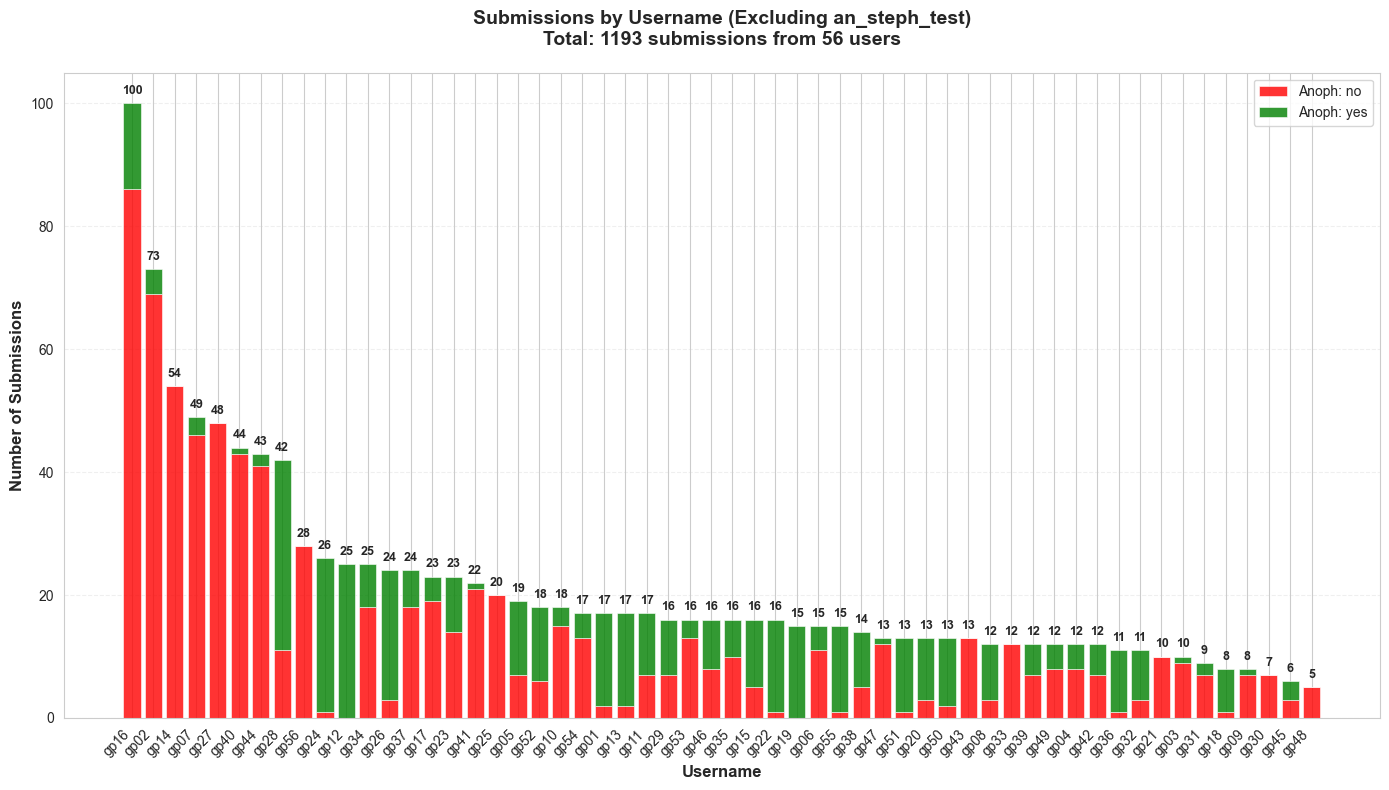


📊 GRAPH SUMMARY:
Username column used: username
Anoph column used: anoph_present
Total records: 1193
Unique users: 56
Average submissions per user: 21.3
Most active user: gp16 (100 submissions)
Excluded user: an_steph_test

🏆 TOP 10 USERS:
------------------------------
 1. gp16: 100 submissions
 2. gp02: 73 submissions
 3. gp14: 54 submissions
 4. gp07: 49 submissions
 5. gp27: 48 submissions
 6. gp40: 44 submissions
 7. gp44: 43 submissions
 8. gp28: 42 submissions
 9. gp56: 28 submissions
10. gp24: 26 submissions

✅ Username graph created successfully!
📁 Graph saved as: username_count_graph.png


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import os

def load_cleaned_data(filename="commcare_cleaned_data.csv"):
    """Load the cleaned data from CSV file"""
    try:
        if not os.path.exists(filename):
            print(f"❌ File '{filename}' not found!")
            print("Please run the data loader script first to create the cleaned data file.")
            return None
        
        df = pd.read_csv(filename)
        print(f"✅ Loaded {len(df)} records from '{filename}'")
        return df
    
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

def find_columns(df, column_type):
    """Find columns based on type"""
    if column_type == 'username':
        return [col for col in df.columns if 'username' in col.lower()]
    elif column_type == 'anoph':
        return [col for col in df.columns if 'anoph' in col.lower()]
    else:
        return []

def create_username_graph(df):
    """Create username count graph colored by anoph_present, excluding 'an_steph_test'"""
    
    # Find username and anoph columns
    username_cols = find_columns(df, 'username')
    anoph_cols = find_columns(df, 'anoph')
    
    if not username_cols:
        print("❌ No username column found")
        return None
    
    username_col = username_cols[0]
    anoph_col = anoph_cols[0] if anoph_cols else None
    
    print(f"✅ Using username column: {username_col}")
    if anoph_col:
        print(f"✅ Using anoph_present column: {anoph_col}")
    
    # Filter out 'an_steph_test'
    df_filtered = df[df[username_col] != 'an_steph_test'].copy()
    
    if df_filtered.empty:
        print("❌ No data found after filtering out 'an_steph_test'")
        return None
    
    print(f"🚫 Excluding user: an_steph_test")
    print(f"📊 Found {df_filtered[username_col].nunique()} unique usernames")
    print(f"📈 Total records: {len(df_filtered)}")
    
    # Get username counts
    username_counts = df_filtered[username_col].value_counts()
    
    # Create the figure
    plt.figure(figsize=(14, 8))
    sns.set_style("whitegrid")
    
    if anoph_col and anoph_col in df_filtered.columns:
        # Create stacked bar chart colored by anoph_present
        crosstab = pd.crosstab(df_filtered[username_col], df_filtered[anoph_col], dropna=False)
        crosstab = crosstab.reindex(username_counts.index, fill_value=0)
        
        print(f"🦟 Anoph_present values: {list(crosstab.columns)}")
        
        # Colors for different anoph values
        color_dict = {}
        for col in crosstab.columns:
            if str(col).lower() == 'yes':
                color_dict[col] = 'green'
            elif str(col).lower() == 'no':
                color_dict[col] = 'red'
            elif str(col) == '___' or str(col).strip() == '' or pd.isna(col):
                color_dict[col] = 'brown'
            else:
                # Default color for any other values
                color_dict[col] = 'gray'
        
        # Create stacked bars
        bottom = np.zeros(len(crosstab))
        for anoph_value in crosstab.columns:
            values = crosstab[anoph_value].values
            plt.bar(range(len(crosstab)), values, 
                   bottom=bottom, label=f'Anoph: {anoph_value}',
                   color=color_dict[anoph_value], alpha=0.8, 
                   edgecolor='white', linewidth=0.5)
            bottom += values
        
        plt.legend(loc='upper right', fontsize=10)
        
        # Print anoph_present distribution
        print(f"\n🦟 ANOPH_PRESENT DISTRIBUTION:")
        print("-" * 40)
        anoph_totals = df_filtered[anoph_col].value_counts()
        for anoph_value, count in anoph_totals.items():
            percentage = (count / len(df_filtered)) * 100
            print(f"{anoph_value}: {count} ({percentage:.1f}%)")
            
    else:
        # Simple bar chart
        plt.bar(range(len(username_counts)), username_counts.values, 
               color='steelblue', alpha=0.8, edgecolor='navy', linewidth=0.5)
    
    # Customize plot
    plt.xticks(range(len(username_counts)), username_counts.index, rotation=45, ha='right', fontsize=10)
    plt.ylabel('Number of Submissions', fontsize=12, fontweight='bold')
    plt.xlabel('Username', fontsize=12, fontweight='bold')
    
    # Update title with stats
    total_records = len(df_filtered)
    unique_users = len(username_counts)
    
    plt.title(f'Submissions by Username (Excluding an_steph_test)\n'
             f'Total: {total_records} submissions from {unique_users} users', 
             fontsize=14, fontweight='bold', pad=20)
    
    # Add value labels on bars
    if len(username_counts) > 0:
        max_count = max(username_counts.values)
        for i, count in enumerate(username_counts.values):
            plt.text(i, count + max_count * 0.01, 
                    f'{int(count)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('username_count_graph.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    
    plt.show()
    
    # Print summary statistics
    print(f"\n📊 GRAPH SUMMARY:")
    print("=" * 50)
    print(f"Username column used: {username_col}")
    if anoph_col:
        print(f"Anoph column used: {anoph_col}")
    print(f"Total records: {total_records}")
    print(f"Unique users: {unique_users}")
    print(f"Average submissions per user: {total_records / unique_users:.1f}")
    print(f"Most active user: {username_counts.index[0]} ({username_counts.iloc[0]} submissions)")
    print(f"Excluded user: an_steph_test")
    
    # Show top 10 users
    print(f"\n🏆 TOP 10 USERS:")
    print("-" * 30)
    for i, (user, count) in enumerate(username_counts.head(10).items(), 1):
        print(f"{i:2d}. {user}: {count} submissions")
    
    return df_filtered

def main():
    print("📊 CommCare Username Graph")
    print("=" * 60)
    
    try:
        # Load the cleaned data
        df = load_cleaned_data()
        if df is None:
            return
        
        print(f"📋 Dataset info: {len(df)} records, {len(df.columns)} columns")
        
        # Create the graph
        print(f"\n📊 Creating username count graph...")
        print(f"🚫 Automatically excluding 'an_steph_test' user")
        
        result = create_username_graph(df)
        
        if result is not None:
            print(f"\n✅ Username graph created successfully!")
            print(f"📁 Graph saved as: username_count_graph.png")
        else:
            print(f"\n❌ Failed to create graph")
            print(f"Please check that your data contains a username column.")
    
    except Exception as e:
        print(f"❌ Unexpected error: {e}")
        import traceback
        print("Full error details:")
        traceback.print_exc()

if __name__ == "__main__":
    main()

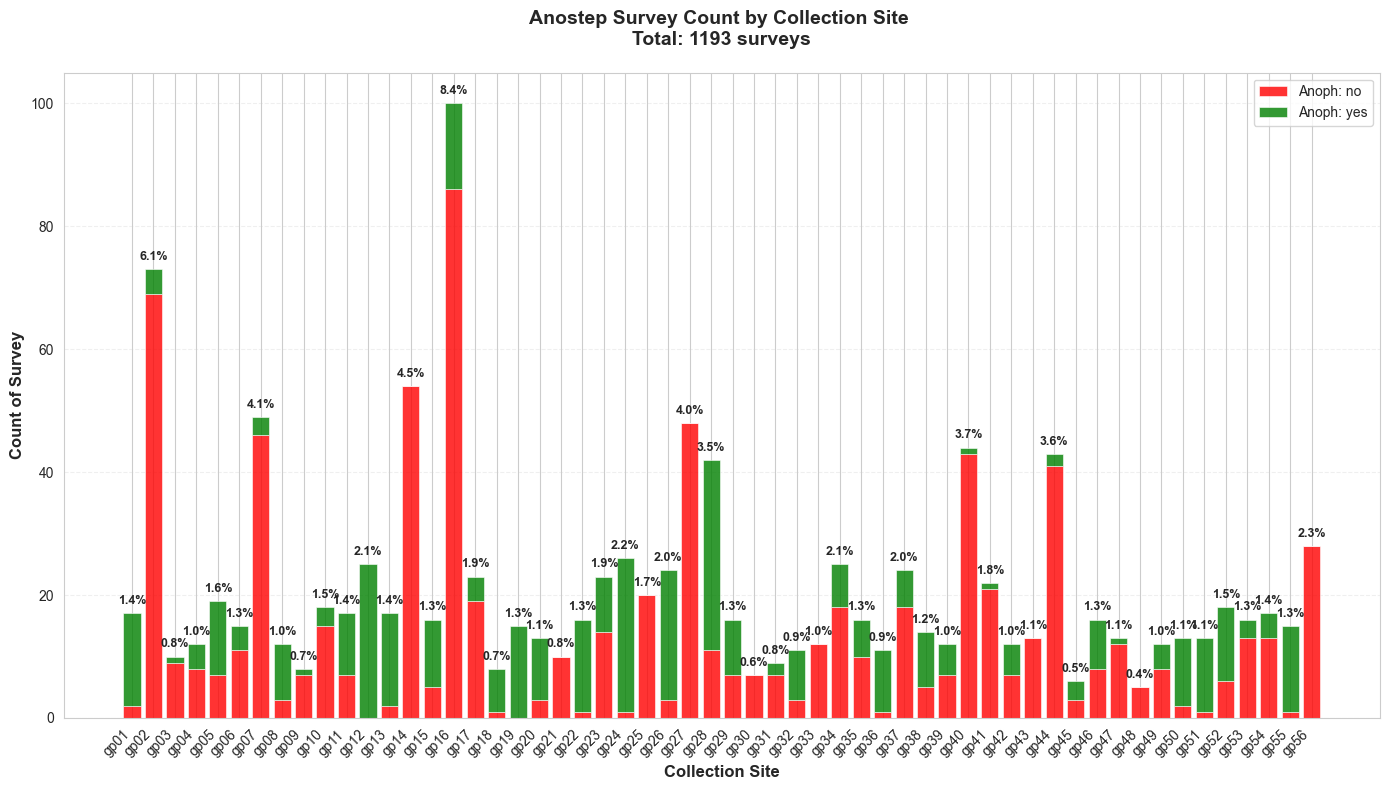

Graph saved as: collection_site_survey_count.png


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import os

def load_cleaned_data(filename="commcare_cleaned_data.csv"):
    """Load the cleaned data from CSV file"""
    try:
        if not os.path.exists(filename):
            print(f"File '{filename}' not found!")
            print("Please run the data loader script first.")
            return None
        
        df = pd.read_csv(filename)
        return df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def find_columns(df, column_type):
    """Find columns based on type"""
    if column_type == 'username':
        return [col for col in df.columns if 'username' in col.lower()]
    elif column_type == 'anoph':
        return [col for col in df.columns if 'anoph' in col.lower()]
    else:
        return []

def create_username_graph(df):
    """Create username count graph colored by anoph_present, excluding 'an_steph_test'"""
    
    # Find username and anoph columns
    username_cols = find_columns(df, 'username')
    anoph_cols = find_columns(df, 'anoph')
    
    if not username_cols:
        print("No username column found")
        return None
    
    username_col = username_cols[0]
    anoph_col = anoph_cols[0] if anoph_cols else None
    
    # Filter out 'an_steph_test' and remove rows with missing usernames
    df_filtered = df[df[username_col] != 'an_steph_test'].copy()
    df_filtered = df_filtered.dropna(subset=[username_col])
    df_filtered = df_filtered[df_filtered[username_col] != '']
    
    if df_filtered.empty:
        print("No data found after filtering")
        return None
    
    # Get username counts and sort alphabetically
    df_filtered[username_col] = df_filtered[username_col].astype(str)
    username_counts = df_filtered[username_col].value_counts()
    username_counts = username_counts.reindex(sorted(username_counts.index, key=str))
    
    # Create the figure
    plt.figure(figsize=(14, 8))
    sns.set_style("whitegrid")
    
    if anoph_col and anoph_col in df_filtered.columns:
        # Create stacked bar chart colored by anoph_present
        crosstab = pd.crosstab(df_filtered[username_col], df_filtered[anoph_col], dropna=False)
        sorted_index = sorted(crosstab.index, key=str)
        crosstab = crosstab.reindex(sorted_index, fill_value=0)
        
        # Colors for different anoph values
        color_dict = {}
        for col in crosstab.columns:
            if str(col).lower() == 'yes':
                color_dict[col] = 'green'
            elif str(col).lower() == 'no':
                color_dict[col] = 'red'
            elif str(col) == '___' or str(col) == '---' or str(col).strip() == '' or pd.isna(col):
                color_dict[col] = 'brown'
            else:
                color_dict[col] = 'gray'
        
        # Create stacked bars
        bottom = np.zeros(len(crosstab))
        for anoph_value in crosstab.columns:
            values = crosstab[anoph_value].values
            plt.bar(range(len(crosstab)), values, 
                   bottom=bottom, label=f'Anoph: {anoph_value}',
                   color=color_dict[anoph_value], alpha=0.8, 
                   edgecolor='white', linewidth=0.5)
            bottom += values
        
        plt.legend(loc='upper right', fontsize=10)
            
    else:
        # Simple bar chart
        plt.bar(range(len(username_counts)), username_counts.values, 
               color='steelblue', alpha=0.8, edgecolor='navy', linewidth=0.5)
    
    # Customize plot
    plt.xticks(range(len(username_counts)), username_counts.index, rotation=45, ha='right', fontsize=10)
    plt.ylabel('Count of Survey', fontsize=12, fontweight='bold')
    plt.xlabel('Collection Site', fontsize=12, fontweight='bold')
    
    # Update title with stats - only show total surveys
    total_surveys = len(df_filtered)
    
    plt.title(f'Anostep Survey Count by Collection Site \n'
             f'Total: {total_surveys} surveys', 
             fontsize=14, fontweight='bold', pad=20)
    
    # # Add value labels on bars
    # if len(username_counts) > 0:
    #     max_count = max(username_counts.values)
    #     for i, count in enumerate(username_counts.values):
    #         plt.text(i, count + max_count * 0.01, 
    #                 f'{int(count)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # plt.grid(axis='y', alpha=0.3, linestyle='--')
    # plt.tight_layout()

    # Add value labels on bars with percentages
    if len(username_counts) > 0:
        max_count = max(username_counts.values)
        total_count = sum(username_counts.values)
    
        for i, count in enumerate(username_counts.values):
            percentage = (count / total_count) * 100
            plt.text(i, count + max_count * 0.01, 
                f'{percentage:.1f}%', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()

    # Save the plot
    plt.savefig('collection_site_survey_count.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    
    plt.show()
    
    return df_filtered

def main():
    try:
        # Load the cleaned data
        df = load_cleaned_data()
        if df is None:
            return
        
        # Create the graph
        result = create_username_graph(df)
        
        if result is not None:
            print(f"Graph saved as: collection_site_survey_count.png")
        else:
            print(f"Failed to create graph")
    
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

Kenya Map with Collection Points
No Kenya shapefile found in current directory.
Searched for: kenya.shp, Kenya.shp, kenya_boundary.shp, etc.
Will create map using coordinate boundaries instead.


Enter path to Kenya shapefile (or press Enter to skip):  



Creating map...
Using GPS column: site_gps
Found 1193 valid GPS coordinates
Using coordinate boundary instead of shapefile
Coloring points by: anoph_present


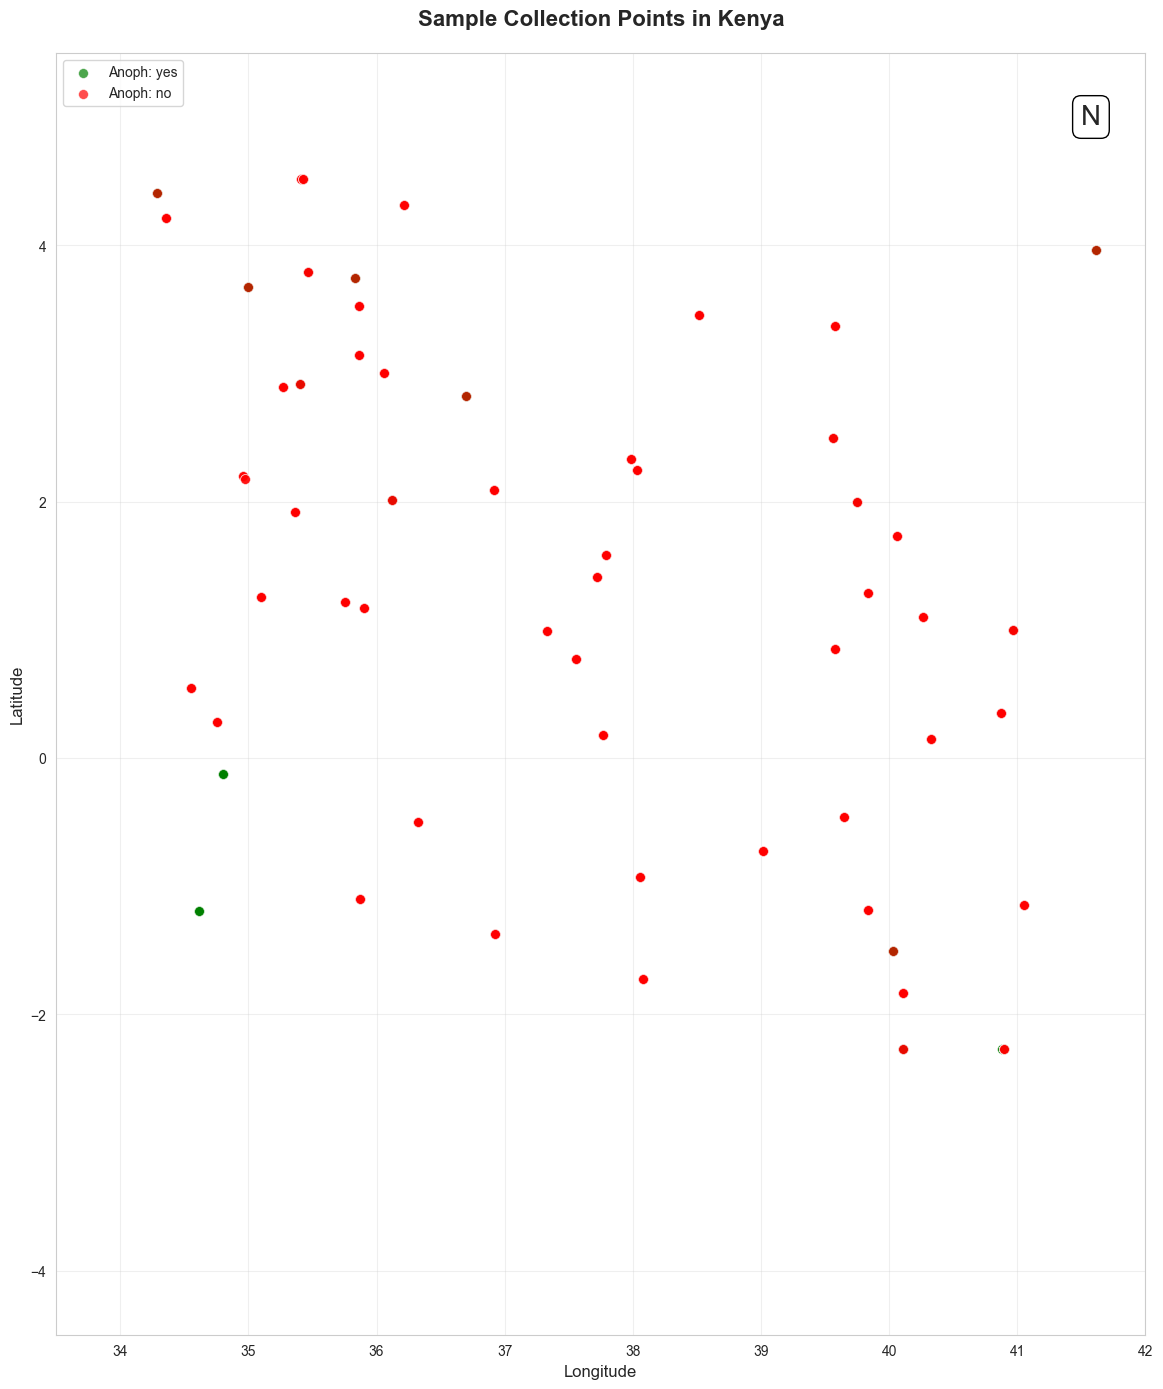


Map created successfully!
Map saved as: kenya_collection_points.png
Total collection points plotted: 1193


In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import os

def load_cleaned_data(filename="commcare_cleaned_data.csv"):
    """Load the cleaned data from CSV file"""
    try:
        if not os.path.exists(filename):
            print(f"File '{filename}' not found!")
            print("Please run the data loader script first.")
            return None
        
        df = pd.read_csv(filename)
        return df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def find_gps_columns(df):
    """Find GPS coordinate columns"""
    site_gps_cols = [col for col in df.columns if 'site_gps' in col.lower()]
    lat_cols = [col for col in df.columns if 'lat' in col.lower()]
    lon_cols = [col for col in df.columns if 'lon' in col.lower()]
    
    return site_gps_cols, lat_cols, lon_cols

def extract_coordinates(df, gps_col):
    """Extract latitude and longitude from GPS coordinates"""
    coordinates = []
    
    for idx, gps_data in df[gps_col].items():
        if pd.isna(gps_data) or str(gps_data).strip() == '':
            continue
            
        try:
            # Handle different GPS coordinate formats
            gps_str = str(gps_data).strip()
            
            # Format: "lat lon" or "lat,lon" or "lat;lon"
            if ' ' in gps_str:
                parts = gps_str.split()
            elif ',' in gps_str:
                parts = gps_str.split(',')
            elif ';' in gps_str:
                parts = gps_str.split(';')
            else:
                continue
                
            if len(parts) >= 2:
                lat = float(parts[0].strip())
                lon = float(parts[1].strip())
                
                # Basic validation for Kenya coordinates
                if -5 <= lat <= 5 and 33 <= lon <= 42:
                    coordinates.append({'latitude': lat, 'longitude': lon, 'index': idx})
                    
        except (ValueError, AttributeError):
            continue
    
    return coordinates

def create_kenya_map_with_points(df, shapefile_path=None):
    """Create map of Kenya with collection points"""
    
    # Find GPS columns
    site_gps_cols, lat_cols, lon_cols = find_gps_columns(df)
    
    if not site_gps_cols and not (lat_cols and lon_cols):
        print("No GPS coordinate columns found")
        print("Looking for columns containing: site_gps, lat, lon")
        return None
    
    coordinates = []
    
    # Try to extract coordinates from site_gps column
    if site_gps_cols:
        gps_col = site_gps_cols[0]
        print(f"Using GPS column: {gps_col}")
        coordinates = extract_coordinates(df, gps_col)
    
    # If no coordinates found, try separate lat/lon columns
    if not coordinates and lat_cols and lon_cols:
        lat_col = lat_cols[0]
        lon_col = lon_cols[0]
        print(f"Using latitude column: {lat_col}")
        print(f"Using longitude column: {lon_col}")
        
        for idx, row in df.iterrows():
            try:
                lat = float(row[lat_col])
                lon = float(row[lon_col])
                
                # Basic validation for Kenya coordinates
                if -5 <= lat <= 5 and 33 <= lon <= 42:
                    coordinates.append({'latitude': lat, 'longitude': lon, 'index': idx})
            except (ValueError, TypeError):
                continue
    
    if not coordinates:
        print("No valid GPS coordinates found")
        return None
    
    print(f"Found {len(coordinates)} valid GPS coordinates")
    
    # Create GeoDataFrame for points
    geometry = [Point(coord['longitude'], coord['latitude']) for coord in coordinates]
    gdf_points = gpd.GeoDataFrame(coordinates, geometry=geometry, crs='EPSG:4326')
    
    # Create the map
    fig, ax = plt.subplots(1, 1, figsize=(12, 14))
    
    # Try to load Kenya shapefile
    kenya_gdf = None
    if shapefile_path and os.path.exists(shapefile_path):
        try:
            kenya_gdf = gpd.read_file(shapefile_path)
            print(f"Loaded shapefile: {shapefile_path}")
        except Exception as e:
            print(f"Error loading shapefile: {e}")
    
    # If no shapefile provided or failed to load, create a simple boundary box
    if kenya_gdf is None:
        print("Using coordinate boundary instead of shapefile")
        # Kenya approximate bounds
        kenya_bounds = {
            'minx': 33.5, 'maxx': 42.0,
            'miny': -4.5, 'maxy': 5.5
        }
        ax.set_xlim(kenya_bounds['minx'], kenya_bounds['maxx'])
        ax.set_ylim(kenya_bounds['miny'], kenya_bounds['maxy'])
        
        # Add grid for reference
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
    else:
        # Plot Kenya boundaries
        kenya_gdf.boundary.plot(ax=ax, linewidth=1.5, edgecolor='black')
        kenya_gdf.plot(ax=ax, color='lightgray', alpha=0.5)
        ax.set_xlim(kenya_gdf.bounds.minx.min() - 0.5, kenya_gdf.bounds.maxx.max() + 0.5)
        ax.set_ylim(kenya_gdf.bounds.miny.min() - 0.5, kenya_gdf.bounds.maxy.max() + 0.5)
    
    # Color points by anoph_present if available
    anoph_cols = [col for col in df.columns if 'anoph' in col.lower()]
    
    if anoph_cols:
        anoph_col = anoph_cols[0]
        print(f"Coloring points by: {anoph_col}")
        
        # Add anoph_present data to points
        anoph_values = []
        for coord in coordinates:
            idx = coord['index']
            anoph_val = df.loc[idx, anoph_col] if idx in df.index else 'unknown'
            anoph_values.append(anoph_val)
        
        gdf_points['anoph_present'] = anoph_values
        
        # Define colors
        color_map = {
            'yes': 'green',
            'no': 'red', 
            '---': 'brown',
            '___': 'brown',
            'unknown': 'gray'
        }
        
        # Plot points with colors
        for anoph_val, color in color_map.items():
            subset = gdf_points[gdf_points['anoph_present'].astype(str).str.lower() == anoph_val.lower()]
            if not subset.empty:
                subset.plot(ax=ax, color=color, markersize=50, alpha=0.7, 
                           label=f'Anoph: {anoph_val}', edgecolor='white', linewidth=0.5)
        
        # Handle any other values
        other_vals = set(gdf_points['anoph_present'].astype(str).str.lower()) - set(color_map.keys())
        for val in other_vals:
            if val not in ['nan', 'none', '']:
                subset = gdf_points[gdf_points['anoph_present'].astype(str).str.lower() == val]
                if not subset.empty:
                    subset.plot(ax=ax, color='purple', markersize=50, alpha=0.7, 
                               label=f'Anoph: {val}', edgecolor='white', linewidth=0.5)
        
        ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
        
    else:
        # Simple blue points if no anoph data
        gdf_points.plot(ax=ax, color='blue', markersize=50, alpha=0.7, 
                       edgecolor='white', linewidth=0.5)
    
    # Customize the map
    ax.set_title('Sample Collection Points in Kenya', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    
    # Remove axes ticks for cleaner look if using shapefile
    if kenya_gdf is not None:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Add north arrow (simple)
    ax.annotate('N', xy=(0.95, 0.95), xycoords='axes fraction', 
                fontsize=20, ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black'))
    
    plt.tight_layout()
    
    # Save the map
    plt.savefig('kenya_collection_points.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    
    plt.show()
    
    return gdf_points

def main():
    """Main function to create Kenya map with collection points"""
    try:
        # Load the cleaned data
        df = load_cleaned_data()
        if df is None:
            return
        
        # Optional: Ask for shapefile path
        print("Kenya Map with Collection Points")
        print("=" * 40)
        
        # Check for common shapefile names
        shapefile_paths = [
            'kenya.shp',
            'Kenya.shp', 
            'kenya_boundary.shp',
            'kenya_admin0.shp',
            'KEN_adm0.shp'
        ]
        
        shapefile_path = None
        for path in shapefile_paths:
            if os.path.exists(path):
                shapefile_path = path
                break
        
        if not shapefile_path:
            print("No Kenya shapefile found in current directory.")
            print("Searched for: kenya.shp, Kenya.shp, kenya_boundary.shp, etc.")
            print("Will create map using coordinate boundaries instead.")
            
            try:
                custom_path = input("Enter path to Kenya shapefile (or press Enter to skip): ").strip()
                if custom_path and os.path.exists(custom_path):
                    shapefile_path = custom_path
            except (EOFError, KeyboardInterrupt):
                pass
        
        # Create the map
        print("\nCreating map...")
        result = create_kenya_map_with_points(df, shapefile_path)
        
        if result is not None:
            print(f"\nMap created successfully!")
            print(f"Map saved as: kenya_collection_points.png")
            print(f"Total collection points plotted: {len(result)}")
        else:
            print("Failed to create map")
    
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import folium
import numpy as np
import os
from folium import plugins

def load_cleaned_data(filename="commcare_cleaned_data.csv"):
    """Load the cleaned data from CSV file"""
    try:
        if not os.path.exists(filename):
            print(f"File '{filename}' not found!")
            print("Please run the data loader script first.")
            return None
        
        df = pd.read_csv(filename)
        return df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def find_gps_columns(df):
    """Find GPS coordinate columns"""
    site_gps_cols = [col for col in df.columns if 'site_gps' in col.lower()]
    lat_cols = [col for col in df.columns if 'lat' in col.lower()]
    lon_cols = [col for col in df.columns if 'lon' in col.lower()]
    
    return site_gps_cols, lat_cols, lon_cols

def extract_coordinates(df, gps_col):
    """Extract latitude and longitude from GPS coordinates"""
    coordinates = []
    
    for idx, gps_data in df[gps_col].items():
        if pd.isna(gps_data) or str(gps_data).strip() == '':
            continue
            
        try:
            # Handle different GPS coordinate formats
            gps_str = str(gps_data).strip()
            
            # Format: "lat lon" or "lat,lon" or "lat;lon"
            if ' ' in gps_str:
                parts = gps_str.split()
            elif ',' in gps_str:
                parts = gps_str.split(',')
            elif ';' in gps_str:
                parts = gps_str.split(';')
            else:
                continue
                
            if len(parts) >= 2:
                lat = float(parts[0].strip())
                lon = float(parts[1].strip())
                
                # Basic validation for Kenya coordinates
                if -5 <= lat <= 5 and 33 <= lon <= 42:
                    # Get additional data for popup
                    row_data = df.loc[idx].to_dict()
                    coordinates.append({
                        'latitude': lat, 
                        'longitude': lon, 
                        'index': idx,
                        'data': row_data
                    })
                    
        except (ValueError, AttributeError):
            continue
    
    return coordinates

def create_interactive_kenya_map(df):
    """Create interactive map of Kenya with collection points"""
    
    # Find GPS columns
    site_gps_cols, lat_cols, lon_cols = find_gps_columns(df)
    
    if not site_gps_cols and not (lat_cols and lon_cols):
        print("No GPS coordinate columns found")
        print("Looking for columns containing: site_gps, lat, lon")
        return None
    
    coordinates = []
    
    # Try to extract coordinates from site_gps column
    if site_gps_cols:
        gps_col = site_gps_cols[0]
        print(f"Using GPS column: {gps_col}")
        coordinates = extract_coordinates(df, gps_col)
    
    # If no coordinates found, try separate lat/lon columns
    if not coordinates and lat_cols and lon_cols:
        lat_col = lat_cols[0]
        lon_col = lon_cols[0]
        print(f"Using latitude column: {lat_col}")
        print(f"Using longitude column: {lon_col}")
        
        for idx, row in df.iterrows():
            try:
                lat = float(row[lat_col])
                lon = float(row[lon_col])
                
                # Basic validation for Kenya coordinates
                if -5 <= lat <= 5 and 33 <= lon <= 42:
                    row_data = row.to_dict()
                    coordinates.append({
                        'latitude': lat, 
                        'longitude': lon, 
                        'index': idx,
                        'data': row_data
                    })
            except (ValueError, TypeError):
                continue
    
    if not coordinates:
        print("No valid GPS coordinates found")
        return None
    
    print(f"Found {len(coordinates)} valid GPS coordinates")
    
    # Calculate center of Kenya for map
    kenya_center = [-0.5, 37.5]  # Approximate center of Kenya
    
    # Create base map
    m = folium.Map(
        location=kenya_center,
        zoom_start=6,
        tiles='OpenStreetMap'
    )
    
    # Add different tile layers with proper attributions
    folium.TileLayer(
        tiles='Stamen Terrain',
        attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.',
        name='Terrain'
    ).add_to(m)
    
    folium.TileLayer(
        tiles='CartoDB positron',
        attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
        name='Light'
    ).add_to(m)
    
    # Define colors for anoph_present
    def get_color(anoph_val):
        anoph_str = str(anoph_val).lower().strip()
        if anoph_str == 'yes':
            return 'green'
        elif anoph_str == 'no':
            return 'red'
        elif anoph_str in ['---', '___', 'nan', '']:
            return 'orange'
        else:
            return 'blue'
    
    def get_icon(anoph_val):
        anoph_str = str(anoph_val).lower().strip()
        if anoph_str == 'yes':
            return 'plus'
        elif anoph_str == 'no':
            return 'minus'
        elif anoph_str in ['---', '___', 'nan', '']:
            return 'question'
        else:
            return 'info'
    
    # Find anoph column
    anoph_cols = [col for col in df.columns if 'anoph' in col.lower()]
    anoph_col = anoph_cols[0] if anoph_cols else None
    
    if anoph_col:
        print(f"Coloring markers by: {anoph_col}")
    
    # Create marker clusters for better performance
    marker_cluster = plugins.MarkerCluster().add_to(m)
    
    # Add markers for each coordinate
    for coord in coordinates:
        lat = coord['latitude']
        lon = coord['longitude']
        data = coord['data']
        
        # Get anoph value for coloring
        anoph_val = data.get(anoph_col, 'unknown') if anoph_col else 'unknown'
        color = get_color(anoph_val)
        icon = get_icon(anoph_val)
        
        # Create popup content with key information
        popup_content = f"""
        <div style='width:300px'>
        <h4><b>Collection Point Details</b></h4>
        <table style='width:100%'>
        """
        
        # Add key fields to popup
        key_fields = ['username', 'site_code', 'county', 'subcounty', 
                     'collection_date', anoph_col, 'culicine_present']
        
        for field in key_fields:
            if field and field in data and not pd.isna(data[field]):
                field_name = field.replace('_', ' ').title()
                popup_content += f"""
                <tr>
                    <td><b>{field_name}:</b></td>
                    <td>{data[field]}</td>
                </tr>
                """
        
        popup_content += f"""
        <tr>
            <td><b>Coordinates:</b></td>
            <td>{lat:.4f}, {lon:.4f}</td>
        </tr>
        </table>
        </div>
        """
        
        # Create marker
        folium.Marker(
            location=[lat, lon],
            popup=folium.Popup(popup_content, max_width=400),
            tooltip=f"Site: {data.get('username', 'Unknown')} | Anoph: {anoph_val}",
            icon=folium.Icon(
                color=color, 
                icon=icon,
                prefix='fa'
            )
        ).add_to(marker_cluster)
    
    # Add a legend
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 180px; height: 120px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <h4>Anopheles Present</h4>
    <p><i class="fa fa-plus" style="color:green"></i> Yes</p>
    <p><i class="fa fa-minus" style="color:red"></i> No</p>
    <p><i class="fa fa-question" style="color:orange"></i> Missing/Unknown</p>
    <p><i class="fa fa-info" style="color:blue"></i> Other</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Add fullscreen button
    plugins.Fullscreen().add_to(m)
    
    # Add measure tool
    plugins.MeasureControl().add_to(m)
    
    # Add minimap
    minimap = plugins.MiniMap()
    m.add_child(minimap)
    
    # Add mouse position
    fmtr = "function(num) {return L.Util.formatNum(num, 4) + ' º '};"
    plugins.MousePosition(
        position='topright',
        separator=' | ',
        empty_string='NaN',
        lng_first=True,
        num_digits=20,
        prefix='Coordinates:',
        lat_formatter=fmtr,
        lng_formatter=fmtr,
    ).add_to(m)
    
    return m

def create_heatmap(df, coordinates):
    """Create a heatmap overlay showing data density"""
    
    # Calculate center of Kenya for map
    kenya_center = [-0.5, 37.5]
    
    # Create base map
    m = folium.Map(
        location=kenya_center,
        zoom_start=6,
        tiles='OpenStreetMap'
    )
    
    # Add alternative tile layer with proper attribution
    folium.TileLayer(
        tiles='CartoDB positron',
        attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
        name='Light'
    ).add_to(m)
    
    # Prepare data for heatmap
    heat_data = [[coord['latitude'], coord['longitude']] for coord in coordinates]
    
    # Add heatmap layer
    plugins.HeatMap(heat_data).add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    return m

def main():
    """Main function to create interactive Kenya map"""
    try:
        # Load the cleaned data
        df = load_cleaned_data()
        if df is None:
            return
        
        print("Interactive Kenya Map with Collection Points")
        print("=" * 45)
        
        # Create the interactive map
        print("Creating interactive map...")
        map_obj = create_interactive_kenya_map(df)
        
        if map_obj is not None:
            # Save the map
            map_filename = 'kenya_collection_points_interactive.html'
            map_obj.save(map_filename)
            print(f"Interactive map saved as: {map_filename}")
            
            # Try to extract coordinates for additional maps
            site_gps_cols, lat_cols, lon_cols = find_gps_columns(df)
            coordinates = []
            
            if site_gps_cols:
                coordinates = extract_coordinates(df, site_gps_cols[0])
            elif lat_cols and lon_cols:
                for idx, row in df.iterrows():
                    try:
                        lat = float(row[lat_cols[0]])
                        lon = float(row[lon_cols[0]])
                        if -5 <= lat <= 5 and 33 <= lon <= 42:
                            coordinates.append({'latitude': lat, 'longitude': lon})
                    except (ValueError, TypeError):
                        continue
            
            # Create heatmap
            if coordinates:
                print("Creating heatmap...")
                heatmap_obj = create_heatmap(df, coordinates)
                heatmap_filename = 'kenya_collection_heatmap.html'
                heatmap_obj.save(heatmap_filename)
                print(f"Heatmap saved as: {heatmap_filename}")
            
            print(f"\nMap features:")
            print(f"- Click markers for detailed information")
            print(f"- Use layer control to switch map styles")
            print(f"- Fullscreen mode available")
            print(f"- Measure distances with measure tool")
            print(f"- Mouse coordinates shown in top-right")
            print(f"- Markers clustered for better performance")
            print(f"\nOpen {map_filename} in your web browser to view the interactive map!")
            
        else:
            print("Failed to create map")
    
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [5]:
import pandas as pd
import folium
import numpy as np
import os
import webbrowser
from folium import plugins

def load_cleaned_data(filename="commcare_cleaned_data.csv"):
    """Load the cleaned data from CSV file"""
    try:
        if not os.path.exists(filename):
            print(f"File '{filename}' not found!")
            print("Please run the data loader script first.")
            return None
        
        df = pd.read_csv(filename)
        return df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def find_gps_columns(df):
    """Find GPS coordinate columns"""
    site_gps_cols = [col for col in df.columns if 'site_gps' in col.lower()]
    lat_cols = [col for col in df.columns if 'lat' in col.lower()]
    lon_cols = [col for col in df.columns if 'lon' in col.lower()]
    
    return site_gps_cols, lat_cols, lon_cols

def extract_coordinates(df, gps_col):
    """Extract latitude and longitude from GPS coordinates"""
    coordinates = []
    
    for idx, gps_data in df[gps_col].items():
        if pd.isna(gps_data) or str(gps_data).strip() == '':
            continue
            
        try:
            # Handle different GPS coordinate formats
            gps_str = str(gps_data).strip()
            
            # Format: "lat lon" or "lat,lon" or "lat;lon"
            if ' ' in gps_str:
                parts = gps_str.split()
            elif ',' in gps_str:
                parts = gps_str.split(',')
            elif ';' in gps_str:
                parts = gps_str.split(';')
            else:
                continue
                
            if len(parts) >= 2:
                lat = float(parts[0].strip())
                lon = float(parts[1].strip())
                
                # Basic validation for Kenya coordinates
                if -5 <= lat <= 5 and 33 <= lon <= 42:
                    # Get additional data for popup
                    row_data = df.loc[idx].to_dict()
                    coordinates.append({
                        'latitude': lat, 
                        'longitude': lon, 
                        'index': idx,
                        'data': row_data
                    })
                    
        except (ValueError, AttributeError):
            continue
    
    return coordinates

def create_interactive_kenya_map(df):
    """Create interactive map of Kenya with collection points"""
    
    # Find GPS columns
    site_gps_cols, lat_cols, lon_cols = find_gps_columns(df)
    
    if not site_gps_cols and not (lat_cols and lon_cols):
        print("No GPS coordinate columns found")
        print("Looking for columns containing: site_gps, lat, lon")
        return None
    
    coordinates = []
    
    # Try to extract coordinates from site_gps column
    if site_gps_cols:
        gps_col = site_gps_cols[0]
        print(f"Using GPS column: {gps_col}")
        coordinates = extract_coordinates(df, gps_col)
    
    # If no coordinates found, try separate lat/lon columns
    if not coordinates and lat_cols and lon_cols:
        lat_col = lat_cols[0]
        lon_col = lon_cols[0]
        print(f"Using latitude column: {lat_col}")
        print(f"Using longitude column: {lon_col}")
        
        for idx, row in df.iterrows():
            try:
                lat = float(row[lat_col])
                lon = float(row[lon_col])
                
                # Basic validation for Kenya coordinates
                if -5 <= lat <= 5 and 33 <= lon <= 42:
                    row_data = row.to_dict()
                    coordinates.append({
                        'latitude': lat, 
                        'longitude': lon, 
                        'index': idx,
                        'data': row_data
                    })
            except (ValueError, TypeError):
                continue
    
    if not coordinates:
        print("No valid GPS coordinates found")
        return None
    
    print(f"Found {len(coordinates)} valid GPS coordinates")
    
    # Calculate center of Kenya for map
    kenya_center = [-0.5, 37.5]  # Approximate center of Kenya
    
    # Create base map
    m = folium.Map(
        location=kenya_center,
        zoom_start=6,
        tiles='OpenStreetMap'
    )
    
    # Add different tile layers with proper attributions
    folium.TileLayer(
        tiles='Stamen Terrain',
        attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.',
        name='Terrain'
    ).add_to(m)
    
    folium.TileLayer(
        tiles='CartoDB positron',
        attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
        name='Light'
    ).add_to(m)
    
    # Define colors for anoph_present
    def get_color(anoph_val):
        anoph_str = str(anoph_val).lower().strip()
        if anoph_str == 'yes':
            return 'green'
        elif anoph_str == 'no':
            return 'red'
        elif anoph_str in ['---', '___', 'nan', '']:
            return 'orange'
        else:
            return 'blue'
    
    def get_icon(anoph_val):
        anoph_str = str(anoph_val).lower().strip()
        if anoph_str == 'yes':
            return 'plus'
        elif anoph_str == 'no':
            return 'minus'
        elif anoph_str in ['---', '___', 'nan', '']:
            return 'question'
        else:
            return 'info'
    
    # Find anoph column
    anoph_cols = [col for col in df.columns if 'anoph' in col.lower()]
    anoph_col = anoph_cols[0] if anoph_cols else None
    
    if anoph_col:
        print(f"Coloring markers by: {anoph_col}")
    
    # Create marker clusters for better performance
    marker_cluster = plugins.MarkerCluster().add_to(m)
    
    # Add markers for each coordinate
    for coord in coordinates:
        lat = coord['latitude']
        lon = coord['longitude']
        data = coord['data']
        
        # Get anoph value for coloring
        anoph_val = data.get(anoph_col, 'unknown') if anoph_col else 'unknown'
        color = get_color(anoph_val)
        icon = get_icon(anoph_val)
        
        # Create popup content with key information
        popup_content = f"""
        <div style='width:300px'>
        <h4><b>Collection Point Details</b></h4>
        <table style='width:100%'>
        """
        
        # Add key fields to popup
        key_fields = ['username', 'site_code', 'county', 'subcounty', 
                     'collection_date', anoph_col, 'culicine_present']
        
        for field in key_fields:
            if field and field in data and not pd.isna(data[field]):
                field_name = field.replace('_', ' ').title()
                popup_content += f"""
                <tr>
                    <td><b>{field_name}:</b></td>
                    <td>{data[field]}</td>
                </tr>
                """
        
        popup_content += f"""
        <tr>
            <td><b>Coordinates:</b></td>
            <td>{lat:.4f}, {lon:.4f}</td>
        </tr>
        </table>
        </div>
        """
        
        # Create marker
        folium.Marker(
            location=[lat, lon],
            popup=folium.Popup(popup_content, max_width=400),
            tooltip=f"Site: {data.get('username', 'Unknown')} | Anoph: {anoph_val}",
            icon=folium.Icon(
                color=color, 
                icon=icon,
                prefix='fa'
            )
        ).add_to(marker_cluster)
    
    # Add a legend
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 180px; height: 120px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <h4>Anopheles Present</h4>
    <p><i class="fa fa-plus" style="color:green"></i> Yes</p>
    <p><i class="fa fa-minus" style="color:red"></i> No</p>
    <p><i class="fa fa-question" style="color:orange"></i> Missing/Unknown</p>
    <p><i class="fa fa-info" style="color:blue"></i> Other</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Add fullscreen button
    plugins.Fullscreen().add_to(m)
    
    # Add measure tool
    plugins.MeasureControl().add_to(m)
    
    # Add minimap
    minimap = plugins.MiniMap()
    m.add_child(minimap)
    
    # Add mouse position
    fmtr = "function(num) {return L.Util.formatNum(num, 4) + ' º '};"
    plugins.MousePosition(
        position='topright',
        separator=' | ',
        empty_string='NaN',
        lng_first=True,
        num_digits=20,
        prefix='Coordinates:',
        lat_formatter=fmtr,
        lng_formatter=fmtr,
    ).add_to(m)
    
    return m

def create_heatmap(df, coordinates):
    """Create a heatmap overlay showing data density"""
    
    # Calculate center of Kenya for map
    kenya_center = [-0.5, 37.5]
    
    # Create base map
    m = folium.Map(
        location=kenya_center,
        zoom_start=6,
        tiles='OpenStreetMap'
    )
    
    # Add alternative tile layer with proper attribution
    folium.TileLayer(
        tiles='CartoDB positron',
        attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
        name='Light'
    ).add_to(m)
    
    # Prepare data for heatmap
    heat_data = [[coord['latitude'], coord['longitude']] for coord in coordinates]
    
    # Add heatmap layer
    plugins.HeatMap(heat_data).add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    return m

def main():
    """Main function to create interactive Kenya map"""
    try:
        # Load the cleaned data
        df = load_cleaned_data()
        if df is None:
            return
        
        print("Interactive Kenya Map with Collection Points")
        print("=" * 45)
        
        # Create the interactive map
        print("Creating interactive map...")
        map_obj = create_interactive_kenya_map(df)
        
        if map_obj is not None:
            # Save the map
            map_filename = 'kenya_collection_points_interactive.html'
            map_obj.save(map_filename)
            print(f"Interactive map saved as: {map_filename}")
            
            # Try to extract coordinates for additional maps
            site_gps_cols, lat_cols, lon_cols = find_gps_columns(df)
            coordinates = []
            
            if site_gps_cols:
                coordinates = extract_coordinates(df, site_gps_cols[0])
            elif lat_cols and lon_cols:
                for idx, row in df.iterrows():
                    try:
                        lat = float(row[lat_cols[0]])
                        lon = float(row[lon_cols[0]])
                        if -5 <= lat <= 5 and 33 <= lon <= 42:
                            coordinates.append({'latitude': lat, 'longitude': lon})
                    except (ValueError, TypeError):
                        continue
            
            # Create heatmap
            if coordinates:
                print("Creating heatmap...")
                heatmap_obj = create_heatmap(df, coordinates)
                heatmap_filename = 'kenya_collection_heatmap.html'
                heatmap_obj.save(heatmap_filename)
                print(f"Heatmap saved as: {heatmap_filename}")
            
            print(f"\nMap features:")
            print(f"- Click markers for detailed information")
            print(f"- Use layer control to switch map styles")
            print(f"- Fullscreen mode available")
            print(f"- Measure distances with measure tool")
            print(f"- Mouse coordinates shown in top-right")
            print(f"- Markers clustered for better performance")
            
            # Automatically open the maps in browser
            try:
                print(f"\nOpening interactive map in browser...")
                map_path = os.path.abspath(map_filename)
                webbrowser.open(f'file://{map_path}')
                
                if coordinates:
                    # Ask if user wants to open heatmap too
                    try:
                        open_heatmap = input("Open heatmap in browser too? (y/n, default=n): ").strip().lower()
                        if open_heatmap == 'y':
                            print("Opening heatmap in browser...")
                            heatmap_path = os.path.abspath(heatmap_filename)
                            webbrowser.open(f'file://{heatmap_path}')
                    except (EOFError, KeyboardInterrupt):
                        print("Skipping heatmap.")
                        
            except Exception as e:
                print(f"Could not automatically open browser: {e}")
                print(f"Please manually open: {map_filename}")
            
        else:
            print("Failed to create map")
    
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Interactive Kenya Map with Collection Points
Creating interactive map...
Using GPS column: site_gps
Found 858 valid GPS coordinates
Coloring markers by: anoph_present
Interactive map saved as: kenya_collection_points_interactive.html
Creating heatmap...
Heatmap saved as: kenya_collection_heatmap.html

Map features:
- Click markers for detailed information
- Use layer control to switch map styles
- Fullscreen mode available
- Measure distances with measure tool
- Mouse coordinates shown in top-right
- Markers clustered for better performance

Opening interactive map in browser...


Open heatmap in browser too? (y/n, default=n):  y


Opening heatmap in browser...


In [4]:
import pandas as pd
import folium
import numpy as np
import os
import webbrowser
from folium import plugins
from datetime import datetime, timedelta
import json

def load_cleaned_data(filename="commcare_cleaned_data.csv"):
    """Load the cleaned data from CSV file"""
    try:
        if not os.path.exists(filename):
            print(f"File '{filename}' not found!")
            print("Please run the data loader script first.")
            return None
        
        df = pd.read_csv(filename)
        return df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def find_gps_columns(df):
    """Find GPS coordinate columns"""
    site_gps_cols = [col for col in df.columns if 'site_gps' in col.lower()]
    lat_cols = [col for col in df.columns if 'lat' in col.lower()]
    lon_cols = [col for col in df.columns if 'lon' in col.lower()]
    
    return site_gps_cols, lat_cols, lon_cols

def find_date_column(df):
    """Find collection date column"""
    date_cols = [col for col in df.columns if 'collection_date' in col.lower() or 
                 'date' in col.lower() or 'received' in col.lower()]
    return date_cols[0] if date_cols else None

def extract_coordinates_with_dates(df, gps_col, date_col):
    """Extract latitude, longitude and dates from GPS coordinates"""
    coordinates = []
    
    for idx, row in df.iterrows():
        gps_data = row[gps_col]
        date_data = row[date_col] if date_col else None
        
        if pd.isna(gps_data) or str(gps_data).strip() == '':
            continue
            
        try:
            # Handle different GPS coordinate formats
            gps_str = str(gps_data).strip()
            
            # Format: "lat lon" or "lat,lon" or "lat;lon"
            if ' ' in gps_str:
                parts = gps_str.split()
            elif ',' in gps_str:
                parts = gps_str.split(',')
            elif ';' in gps_str:
                parts = gps_str.split(';')
            else:
                continue
                
            if len(parts) >= 2:
                lat = float(parts[0].strip())
                lon = float(parts[1].strip())
                
                # Basic validation for Kenya coordinates
                if -5 <= lat <= 5 and 33 <= lon <= 42:
                    # Parse date
                    collection_date = None
                    week_number = None
                    
                    if date_col and not pd.isna(date_data):
                        try:
                            collection_date = pd.to_datetime(date_data)
                            # Calculate week number from start of year
                            week_number = collection_date.isocalendar()[1]
                        except:
                            collection_date = None
                            week_number = None
                    
                    # Get additional data for popup
                    row_data = row.to_dict()
                    coordinates.append({
                        'latitude': lat, 
                        'longitude': lon, 
                        'index': idx,
                        'data': row_data,
                        'collection_date': collection_date,
                        'week_number': week_number,
                        'date_string': collection_date.strftime('%Y-%m-%d') if collection_date else 'Unknown'
                    })
                    
        except (ValueError, AttributeError):
            continue
    
    return coordinates

def create_time_slider_map(df):
    """Create interactive map with time slider for collection weeks"""
    
    # Find GPS and date columns
    site_gps_cols, lat_cols, lon_cols = find_gps_columns(df)
    date_col = find_date_column(df)
    
    if not site_gps_cols and not (lat_cols and lon_cols):
        print("No GPS coordinate columns found")
        return None
    
    if not date_col:
        print("No collection date column found")
        print("Available columns:", df.columns.tolist())
        return None
    
    coordinates = []
    
    # Extract coordinates with dates
    if site_gps_cols:
        gps_col = site_gps_cols[0]
        print(f"Using GPS column: {gps_col}")
        print(f"Using date column: {date_col}")
        coordinates = extract_coordinates_with_dates(df, gps_col, date_col)
    
    if not coordinates:
        print("No valid GPS coordinates with dates found")
        return None
    
    # Filter out coordinates without dates for time slider
    coordinates_with_dates = [c for c in coordinates if c['collection_date'] is not None]
    
    if not coordinates_with_dates:
        print("No coordinates with valid dates found")
        return None
    
    print(f"Found {len(coordinates_with_dates)} coordinates with valid dates")
    
    # Group by week
    week_groups = {}
    for coord in coordinates_with_dates:
        week_key = f"{coord['collection_date'].year}-W{coord['week_number']:02d}"
        if week_key not in week_groups:
            week_groups[week_key] = []
        week_groups[week_key].append(coord)
    
    print(f"Data spans {len(week_groups)} weeks")
    
    # Calculate center of Kenya for map
    kenya_center = [-0.5, 37.5]
    
    # Create base map
    m = folium.Map(
        location=kenya_center,
        zoom_start=6,
        tiles='OpenStreetMap'
    )
    
    # Add different tile layers with proper attributions
    folium.TileLayer(
        tiles='Stamen Terrain',
        attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.',
        name='Terrain'
    ).add_to(m)
    
    folium.TileLayer(
        tiles='CartoDB positron',
        attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
        name='Light'
    ).add_to(m)
    
    # Define colors for anoph_present
    def get_color(anoph_val):
        anoph_str = str(anoph_val).lower().strip()
        if anoph_str == 'yes':
            return 'green'
        elif anoph_str == 'no':
            return 'red'
        elif anoph_str in ['---', '___', 'nan', '']:
            return 'orange'
        else:
            return 'blue'
    
    def get_icon(anoph_val):
        anoph_str = str(anoph_val).lower().strip()
        if anoph_str == 'yes':
            return 'plus'
        elif anoph_str == 'no':
            return 'minus'
        elif anoph_str in ['---', '___', 'nan', '']:
            return 'question'
        else:
            return 'info'
    
    # Find anoph column
    anoph_cols = [col for col in df.columns if 'anoph' in col.lower()]
    anoph_col = anoph_cols[0] if anoph_cols else None
    
    if anoph_col:
        print(f"Coloring markers by: {anoph_col}")
    
    # Create time-indexed data for TimestampedGeoJson
    features = []
    
    for week_key, coords_in_week in week_groups.items():
        for coord in coords_in_week:
            data = coord['data']
            anoph_val = data.get(anoph_col, 'unknown') if anoph_col else 'unknown'
            
            # Create popup content
            popup_content = f"""
            <div style='width:300px'>
            <h4><b>Collection Point Details</b></h4>
            <table style='width:100%'>
            <tr><td><b>Week:</b></td><td>{week_key}</td></tr>
            <tr><td><b>Date:</b></td><td>{coord['date_string']}</td></tr>
            """
            
            # Add key fields to popup
            key_fields = ['username', 'site_code', 'county', 'subcounty', 
                         anoph_col, 'culicine_present']
            
            for field in key_fields:
                if field and field in data and not pd.isna(data[field]):
                    field_name = field.replace('_', ' ').title()
                    popup_content += f"""
                    <tr><td><b>{field_name}:</b></td><td>{data[field]}</td></tr>
                    """
            
            popup_content += f"""
            <tr><td><b>Coordinates:</b></td><td>{coord['latitude']:.4f}, {coord['longitude']:.4f}</td></tr>
            </table></div>
            """
            
            # Create feature for TimestampedGeoJson
            feature = {
                'type': 'Feature',
                'geometry': {
                    'type': 'Point',
                    'coordinates': [coord['longitude'], coord['latitude']]
                },
                'properties': {
                    'time': coord['collection_date'].strftime('%Y-%m-%d'),
                    'popup': popup_content,
                    'tooltip': f"Site: {data.get('username', 'Unknown')} | Week: {week_key} | Anoph: {anoph_val}",
                    'icon': get_icon(anoph_val),
                    'color': get_color(anoph_val),
                    'anoph': anoph_val
                }
            }
            features.append(feature)
    
    # Create TimestampedGeoJson
    timestamped_geojson = plugins.TimestampedGeoJson(
        {
            'type': 'FeatureCollection',
            'features': features
        },
        period='P7D',  # 7 days (1 week) periods
        add_last_point=True,
        auto_play=False,
        loop=False,
        max_speed=5,
        loop_button=True,
        date_options='YYYY-MM-DD',
        time_slider_drag_update=True
    )
    
    timestamped_geojson.add_to(m)
    
    # Add a legend
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 200px; height: 140px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <h4>Collection Points by Week</h4>
    <p><i class="fa fa-plus" style="color:green"></i> Anoph: Yes</p>
    <p><i class="fa fa-minus" style="color:red"></i> Anoph: No</p>
    <p><i class="fa fa-question" style="color:orange"></i> Missing/Unknown</p>
    <p><i class="fa fa-info" style="color:blue"></i> Other</p>
    <p><small>Use time slider to filter by week</small></p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Add fullscreen button
    plugins.Fullscreen().add_to(m)
    
    # Add measure tool
    plugins.MeasureControl().add_to(m)
    
    # Add minimap
    minimap = plugins.MiniMap()
    m.add_child(minimap)
    
    return m, week_groups

def main():
    """Main function to create interactive Kenya map with time slider"""
    try:
        # Load the cleaned data
        df = load_cleaned_data()
        if df is None:
            return
        
        print("Interactive Kenya Map with Time Slider")
        print("=" * 40)
        
        # Create the time slider map
        print("Creating time-slider map...")
        result = create_time_slider_map(df)
        
        if result is not None:
            map_obj, week_groups = result
            
            # Save the map
            map_filename = 'kenya_time_slider_map.html'
            map_obj.save(map_filename)
            print(f"Time-slider map saved as: {map_filename}")
            
            # Print week summary
            print(f"\nWeek Summary:")
            print("-" * 30)
            for week, coords in sorted(week_groups.items()):
                print(f"{week}: {len(coords)} collection points")
            
            print(f"\nMap features:")
            print(f"- Time slider to filter by collection week")
            print(f"- Play button for animated timeline")
            print(f"- Click markers for detailed information")
            print(f"- Multiple map layer options")
            print(f"- Fullscreen mode and measurement tools")
            
            # Automatically open the map in browser
            try:
                print(f"\nOpening time-slider map in browser...")
                map_path = os.path.abspath(map_filename)
                webbrowser.open(f'file://{map_path}')
                        
            except Exception as e:
                print(f"Could not automatically open browser: {e}")
                print(f"Please manually open: {map_filename}")
            
        else:
            print("Failed to create time-slider map")
    
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Interactive Kenya Map with Time Slider
Creating time-slider map...
Using GPS column: site_gps
Using date column: collection_date
Found 1097 coordinates with valid dates
Data spans 11 weeks
Coloring markers by: anoph_present
Time-slider map saved as: kenya_time_slider_map.html

Week Summary:
------------------------------
2022-W42: 1 collection points
2025-W31: 24 collection points
2025-W32: 46 collection points
2025-W33: 75 collection points
2025-W34: 146 collection points
2025-W35: 152 collection points
2025-W36: 181 collection points
2025-W37: 114 collection points
2025-W38: 146 collection points
2025-W39: 202 collection points
2025-W40: 10 collection points

Map features:
- Time slider to filter by collection week
- Play button for animated timeline
- Click markers for detailed information
- Multiple map layer options
- Fullscreen mode and measurement tools

Opening time-slider map in browser...


In [3]:
import pandas as pd
import folium
import numpy as np
import os
import webbrowser
from folium import plugins
from datetime import datetime

def load_cleaned_data(filename="commcare_cleaned_data.csv"):
    """Load the cleaned data from CSV file"""
    try:
        if not os.path.exists(filename):
            print(f"File '{filename}' not found!")
            print("Please run the data loader script first.")
            return None
        
        df = pd.read_csv(filename)
        return df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def find_gps_columns(df):
    """Find GPS coordinate columns"""
    site_gps_cols = [col for col in df.columns if 'site_gps' in col.lower()]
    lat_cols = [col for col in df.columns if 'lat' in col.lower()]
    lon_cols = [col for col in df.columns if 'lon' in col.lower()]
    
    return site_gps_cols, lat_cols, lon_cols

def extract_coordinates_for_heatmap(df, gps_col):
    """Extract latitude and longitude for heatmap"""
    coordinates = []
    
    for idx, gps_data in df[gps_col].items():
        if pd.isna(gps_data) or str(gps_data).strip() == '':
            continue
            
        try:
            # Handle different GPS coordinate formats
            gps_str = str(gps_data).strip()
            
            # Format: "lat lon" or "lat,lon" or "lat;lon"
            if ' ' in gps_str:
                parts = gps_str.split()
            elif ',' in gps_str:
                parts = gps_str.split(',')
            elif ';' in gps_str:
                parts = gps_str.split(';')
            else:
                continue
                
            if len(parts) >= 2:
                lat = float(parts[0].strip())
                lon = float(parts[1].strip())
                
                # Basic validation for Kenya coordinates
                if -5 <= lat <= 5 and 33 <= lon <= 42:
                    coordinates.append([lat, lon])
                    
        except (ValueError, AttributeError):
            continue
    
    return coordinates

def create_density_heatmap(df):
    """Create a density heatmap of collection points"""
    
    # Find GPS columns
    site_gps_cols, lat_cols, lon_cols = find_gps_columns(df)
    
    if not site_gps_cols and not (lat_cols and lon_cols):
        print("No GPS coordinate columns found")
        return None
    
    coordinates = []
    
    # Extract coordinates
    if site_gps_cols:
        gps_col = site_gps_cols[0]
        print(f"Using GPS column: {gps_col}")
        coordinates = extract_coordinates_for_heatmap(df, gps_col)
    elif lat_cols and lon_cols:
        lat_col = lat_cols[0]
        lon_col = lon_cols[0]
        print(f"Using latitude column: {lat_col}")
        print(f"Using longitude column: {lon_col}")
        
        for idx, row in df.iterrows():
            try:
                lat = float(row[lat_col])
                lon = float(row[lon_col])
                
                if -5 <= lat <= 5 and 33 <= lon <= 42:
                    coordinates.append([lat, lon])
            except (ValueError, TypeError):
                continue
    
    if not coordinates:
        print("No valid GPS coordinates found for heatmap")
        return None
    
    print(f"Found {len(coordinates)} coordinates for heatmap")
    
    # Calculate center of Kenya
    kenya_center = [-0.5, 37.5]
    
    # Create base map
    m = folium.Map(
        location=kenya_center,
        zoom_start=6,
        tiles='OpenStreetMap'
    )
    
    # Add alternative tile layers
    folium.TileLayer(
        tiles='Stamen Terrain',
        attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.',
        name='Terrain'
    ).add_to(m)
    
    folium.TileLayer(
        tiles='CartoDB positron',
        attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
        name='Light'
    ).add_to(m)
    
    folium.TileLayer(
        tiles='CartoDB dark_matter',
        attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
        name='Dark'
    ).add_to(m)
    
    # Create heatmap layer
    heat_map = plugins.HeatMap(
        coordinates,
        min_opacity=0.2,
        max_zoom=18,
        radius=25,
        blur=15,
        gradient={
            0.4: 'blue',
            0.65: 'lime', 
            0.8: 'orange',
            1.0: 'red'
        }
    )
    heat_map.add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Add fullscreen button
    plugins.Fullscreen().add_to(m)
    
    # Add measure tool
    plugins.MeasureControl().add_to(m)
    
    # Add minimap
    minimap = plugins.MiniMap()
    m.add_child(minimap)
    
    # Add mouse position
    fmtr = "function(num) {return L.Util.formatNum(num, 4) + ' º '};"
    plugins.MousePosition(
        position='topright',
        separator=' | ',
        empty_string='NaN',
        lng_first=True,
        num_digits=20,
        prefix='Coordinates:',
        lat_formatter=fmtr,
        lng_formatter=fmtr,
    ).add_to(m)
    
    # Add legend for heatmap
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 200px; height: 120px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <h4>Collection Density</h4>
    <div style="background: linear-gradient(to right, blue, lime, orange, red); height: 20px; width: 100%; margin: 10px 0;"></div>
    <div style="display: flex; justify-content: space-between; font-size: 12px;">
        <span>Low</span>
        <span>High</span>
    </div>
    <p style="font-size: 12px; margin-top: 10px;">
        Total Points: ''' + str(len(coordinates)) + '''
    </p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

def create_cluster_heatmap(df):
    """Create a heatmap with marker clusters"""
    
    # Find GPS columns  
    site_gps_cols, lat_cols, lon_cols = find_gps_columns(df)
    
    if not site_gps_cols and not (lat_cols and lon_cols):
        print("No GPS coordinate columns found")
        return None
    
    coordinates = []
    
    # Extract coordinates with additional data
    if site_gps_cols:
        gps_col = site_gps_cols[0]
        
        for idx, row in df.iterrows():
            gps_data = row[gps_col]
            
            if pd.isna(gps_data) or str(gps_data).strip() == '':
                continue
                
            try:
                gps_str = str(gps_data).strip()
                
                if ' ' in gps_str:
                    parts = gps_str.split()
                elif ',' in gps_str:
                    parts = gps_str.split(',')
                elif ';' in gps_str:
                    parts = gps_str.split(';')
                else:
                    continue
                    
                if len(parts) >= 2:
                    lat = float(parts[0].strip())
                    lon = float(parts[1].strip())
                    
                    if -5 <= lat <= 5 and 33 <= lon <= 42:
                        coordinates.append({
                            'lat': lat,
                            'lon': lon,
                            'data': row.to_dict()
                        })
                        
            except (ValueError, AttributeError):
                continue
    
    if not coordinates:
        print("No valid coordinates for cluster map")
        return None
    
    # Calculate center of Kenya
    kenya_center = [-0.5, 37.5]
    
    # Create base map
    m = folium.Map(
        location=kenya_center,
        zoom_start=6,
        tiles='CartoDB positron'
    )
    
    # Create marker cluster
    marker_cluster = plugins.MarkerCluster(
        name='Collection Points',
        options={
            'disableClusteringAtZoom': 10,
            'maxClusterRadius': 50
        }
    ).add_to(m)
    
    # Find anoph column
    anoph_cols = [col for col in df.columns if 'anoph' in col.lower()]
    anoph_col = anoph_cols[0] if anoph_cols else None
    
    # Add markers to cluster
    for coord in coordinates:
        data = coord['data']
        anoph_val = data.get(anoph_col, 'unknown') if anoph_col else 'unknown'
        
        # Simple popup
        popup_text = f"""
        Site: {data.get('username', 'Unknown')}
        Anoph: {anoph_val}
        Coordinates: {coord['lat']:.4f}, {coord['lon']:.4f}
        """
        
        folium.CircleMarker(
            location=[coord['lat'], coord['lon']],
            radius=5,
            popup=popup_text,
            color='red' if str(anoph_val).lower() == 'yes' else 'blue',
            fillColor='red' if str(anoph_val).lower() == 'yes' else 'blue',
            fillOpacity=0.7
        ).add_to(marker_cluster)
    
    # Add heatmap layer
    heat_data = [[coord['lat'], coord['lon']] for coord in coordinates]
    heat_map = plugins.HeatMap(heat_data, name='Density Heatmap')
    heat_map.add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    return m

def main():
    """Main function to create heatmap visualizations"""
    try:
        # Load the cleaned data
        df = load_cleaned_data()
        if df is None:
            return
        
        print("Kenya Collection Points Heatmap Generator")
        print("=" * 45)
        
        print("\nChoose heatmap type:")
        print("1. Density Heatmap (heat intensity)")
        print("2. Cluster + Heatmap (markers + density)")
        print("3. Both (creates two files)")
        
        try:
            choice = input("Enter choice (1-3, default=1): ").strip() or "1"
        except (EOFError, KeyboardInterrupt):
            choice = "1"
        
        maps_created = []
        
        if choice in ["1", "3"]:
            print("\nCreating density heatmap...")
            density_map = create_density_heatmap(df)
            
            if density_map:
                filename = 'kenya_density_heatmap.html'
                density_map.save(filename)
                maps_created.append(filename)
                print(f"Density heatmap saved as: {filename}")
        
        if choice in ["2", "3"]:
            print("\nCreating cluster heatmap...")
            cluster_map = create_cluster_heatmap(df)
            
            if cluster_map:
                filename = 'kenya_cluster_heatmap.html'
                cluster_map.save(filename)
                maps_created.append(filename)
                print(f"Cluster heatmap saved as: {filename}")
        
        if maps_created:
            print(f"\nHeatmap features:")
            print(f"- Multiple map layer options")
            print(f"- Fullscreen mode available")
            print(f"- Measure distances with measure tool")
            print(f"- Mouse coordinates display")
            print(f"- Density visualization of collection activity")
            
            # Open maps in browser
            for filename in maps_created:
                try:
                    print(f"\nOpening {filename} in browser...")
                    map_path = os.path.abspath(filename)
                    webbrowser.open(f'file://{map_path}')
                except Exception as e:
                    print(f"Could not open {filename}: {e}")
        else:
            print("No heatmaps were created")
    
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Kenya Collection Points Heatmap Generator

Choose heatmap type:
1. Density Heatmap (heat intensity)
2. Cluster + Heatmap (markers + density)
3. Both (creates two files)


Enter choice (1-3, default=1):  2



Creating cluster heatmap...
Cluster heatmap saved as: kenya_cluster_heatmap.html

Heatmap features:
- Multiple map layer options
- Fullscreen mode available
- Measure distances with measure tool
- Mouse coordinates display
- Density visualization of collection activity

Opening kenya_cluster_heatmap.html in browser...
